In [1]:
from matplotlib.image import imread
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
import time
import transformers
import os
from gensim.models import Word2Vec
import gensim
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
import tensorflow.keras
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import functions as fct
from pandas_profiling import ProfileReport
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from tqdm import tqdm

# traitement du texte
import re
import string
import nltk
from collections import Counter



C:\Users\Helene\anaconda3\envs\P6_venv_def\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


# Chargement des données

In [3]:
data = pd.read_csv(
    '../01_DATA/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
data.shape



(1050, 15)

In [4]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [5]:
fct.pourcent_NA_df(data)



Il y a 97.83% valeurs renseignées (soit 2.17 % de valeurs manquantes) dans l'intégralité du df


<AxesSubplot:>

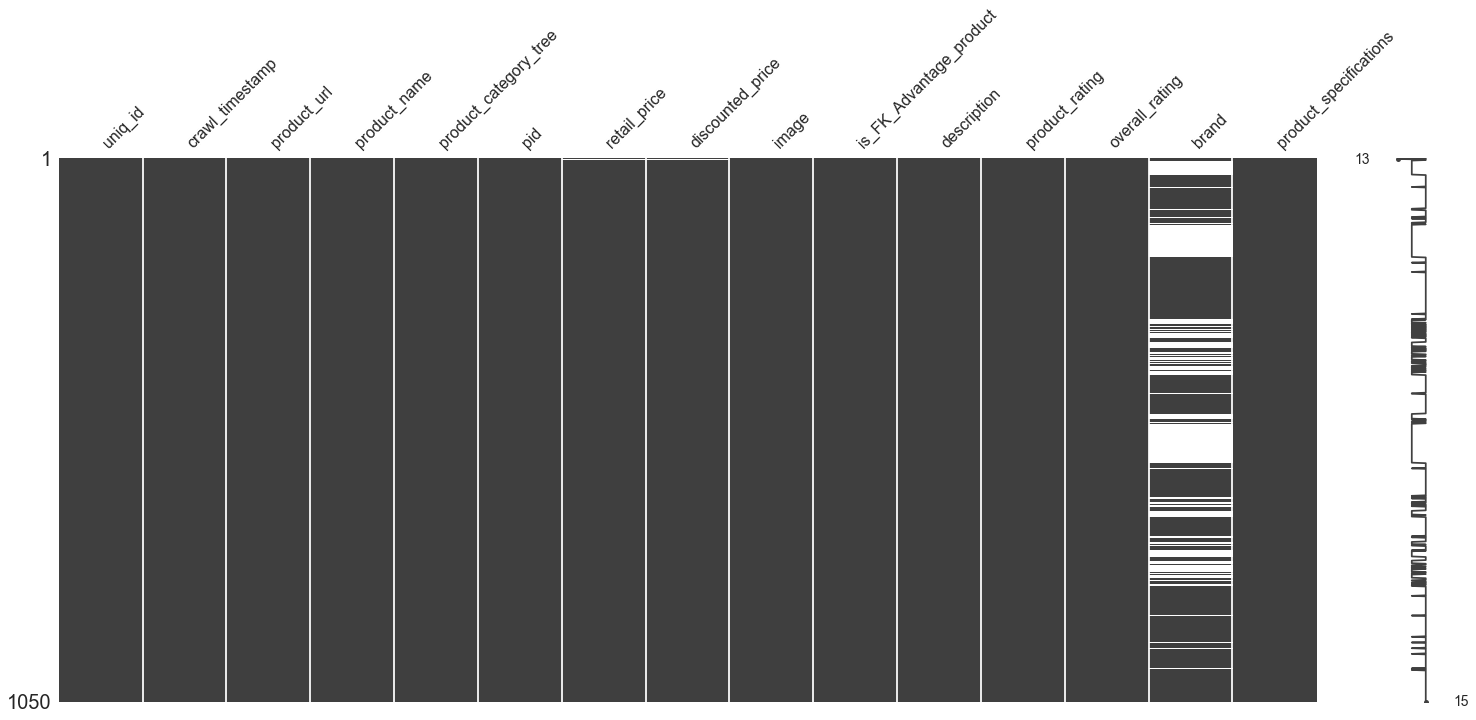

In [6]:
%matplotlib inline
msno.matrix(data)



C'est principalement la colonne brand qui est incomplète

In [7]:
# profile = ProfileReport(data)
# profile.to_file(output_file='rapport_data.html')



In [8]:
data.head()



uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

# Catégorisation cible (product_category_tree)

In [9]:
data.product_category_tree.value_counts()



["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         22
["Home Furnishing >> Bath Linen >> Towels"]                                           19
                                                                                      ..
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]     1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]           1
["Watches >> Wrist Watches >> Petrol Wrist Watches"]                                   1
Name: product_categor

plusieurs niveaux de catégories, séparés par des '>>'

## retrait caracteres [  ]  " et tokenization

In [10]:
caracteres = ['[', ']', '"']



In [11]:


def remove_car(text, caracteres):
    # pour enlever des caracteres specifiques
    text_nocar = "".join([char for char in text if char not in caracteres])
    return text_nocar


def tokenize(text, separator):
    # function to tokenize words
    tokens = re.split(separator, text)
    return tokens



In [12]:
data['categorie_no_car'] = data.product_category_tree.apply(
    lambda x: remove_car(x, caracteres))



In [13]:
data['categorie_token'] = data.categorie_no_car.apply(
    lambda x: tokenize(x, '>> '))



In [14]:
nb_level_max = 0
for i in range(data.shape[0]):
    nb_level = len(data['categorie_token'][i])
    if nb_level > nb_level_max:
        nb_level_max = nb_level
print("Il y a {} catégories au maximum".format(nb_level_max))



Il y a 7 catégories au maximum


## investigation du niveau de categorisation interessant

----------
Niveau de catégorisation 0
Nombre de catégories : 7
----------
Niveau de catégorisation 1
Nombre de catégories : 63
----------
Niveau de catégorisation 2
Nombre de catégories : 247
----------
Niveau de catégorisation 3
Nombre de catégories : 351
----------
Niveau de catégorisation 4
Nombre de catégories : 298
----------
Niveau de catégorisation 5
Nombre de catégories : 118
----------
Niveau de catégorisation 6
Nombre de catégories : 58


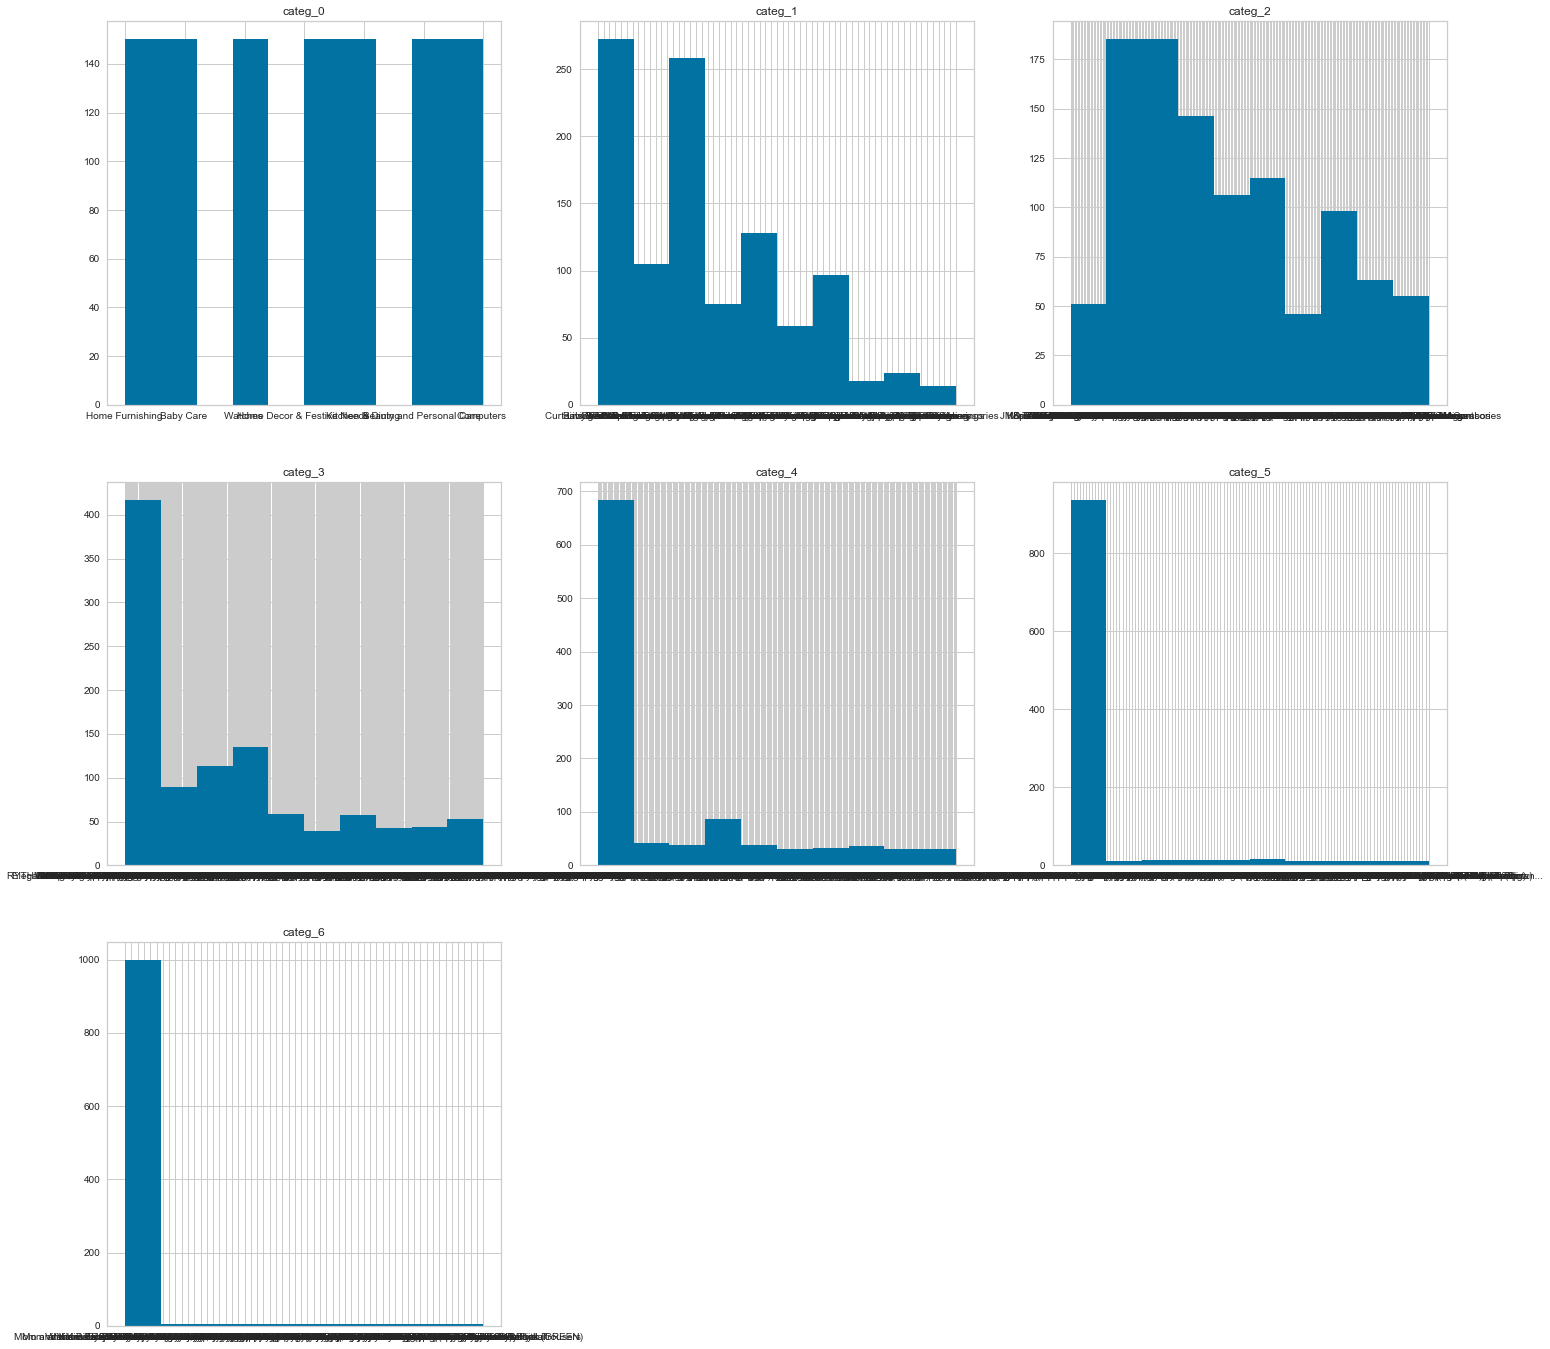

In [15]:
plt.figure(figsize=(24, 24))
for level in range(nb_level_max):
    name = 'categ_' + str(level)
    for i in range(data.shape[0]):
        try:
            data.loc[i, name] = data.loc[i, 'categorie_token'][level]
        except:
            data.loc[i, name] = 'None'
            pass
    nb_categ = len(data[name].unique())
    print('-'*10)
    print('Niveau de catégorisation {}'.format(level))
    print('Nombre de catégories : {}'.format(nb_categ))
    plt.subplot(3, 3, level+1)
    plt.hist(data[name])
    plt.title(name)



    A priori seule la première catégorie est suffisamment équilibrée. Il y a donc de fortes chances que l'apprentissage non supervisé converge vers une classification de ~7 classes de produits (à vérifier)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

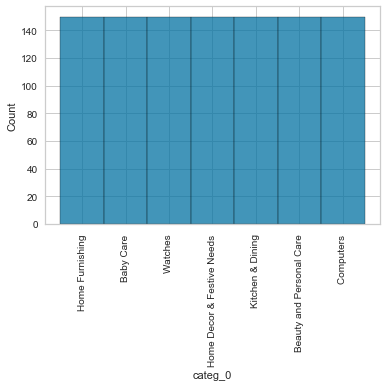

In [16]:
sns.histplot(data=data, x='categ_0')
plt.xticks(rotation=90)


In [17]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [18]:
# export des catégories pour calcul ARI avec classif images
data_to_export = data[['uniq_id', 'image', 'categ_0']]
data_to_export.to_csv('../01_DATA/target.csv')


In [19]:
# retrait des colonnes de catégorie > 0
liste = ['categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6']
data = data.drop(liste, axis=1)


# Nettoyage
    Les colonnes crawl_timestamp, pid, is_FK_Advantage_product, product_rating et overall_rating et 'retail_price', 'discounted_price' ne sont pas nécessaires.

In [20]:
liste = ['crawl_timestamp', 'pid',
         'is_FK_Advantage_product',
         'product_rating', 'overall_rating',
         'retail_price', 'discounted_price']
data = data.drop(liste, axis=1)



In [21]:
data.shape



(1050, 11)

In [22]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uniq_id                 1050 non-null   object
 1   product_url             1050 non-null   object
 2   product_name            1050 non-null   object
 3   product_category_tree   1050 non-null   object
 4   image                   1050 non-null   object
 5   description             1050 non-null   object
 6   brand                   712 non-null    object
 7   product_specifications  1049 non-null   object
 8   categorie_no_car        1050 non-null   object
 9   categorie_token         1050 non-null   object
 10  categ_0                 1050 non-null   object
dtypes: object(11)
memory usage: 90.4+ KB


In [23]:
# remplacement valeurs nulles par 'NaN'
data = data.fillna('NaN')


In [24]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uniq_id                 1050 non-null   object
 1   product_url             1050 non-null   object
 2   product_name            1050 non-null   object
 3   product_category_tree   1050 non-null   object
 4   image                   1050 non-null   object
 5   description             1050 non-null   object
 6   brand                   1050 non-null   object
 7   product_specifications  1050 non-null   object
 8   categorie_no_car        1050 non-null   object
 9   categorie_token         1050 non-null   object
 10  categ_0                 1050 non-null   object
dtypes: object(11)
memory usage: 90.4+ KB


## Création de la target classification pour calcul d'ARI

In [25]:
labels = data["categ_0"]



In [26]:
# transormation des labels en entiers (nécessaire pour calculer matrice de confusion)
labelencoder = LabelEncoder()
labelencoder.fit(labels)
labels_int = labelencoder.transform(labels)
labels_int


array([4, 0, 0, ..., 0, 0, 0])

In [27]:
list_labels = data.categ_0.sort_values().unique()
list_labels


array(['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
       'Home Decor & Festive Needs ', 'Home Furnishing ',
       'Kitchen & Dining ', 'Watches '], dtype=object)

 # Fonctions communes

In [28]:


def clustering_7classes(X, labels):
    cls = KMeans(n_clusters=7, random_state=0)
    cls.fit(X)

    y_pred = cls.labels_

    ARI = adjusted_rand_score(labels, y_pred)
    print("ARI : {:.3f}".format(ARI))
    return y_pred, ARI


In [29]:


def visu_resultats(features, y_pred, ARI, y_true=data.categ_0):
    # Visualisation sur tsne
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 3, 1)
    sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y_true)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Catégorisation de référence")

    plt.subplot(1, 3, 2)
    sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y_pred)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Résultat du clustering automatique\nARI = {:.3f}".format(ARI))

    plt.subplot(1, 3, 3)
    plt.hist(x=y_pred, bins=7)


In [30]:


def erreur_attribution(y_true, y_pred, labels=labels):
    '''
    calcul et affichage de la matrice de confusion pour identifier
    les classes qui sont bien prédites
    '''
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # Alignement le long de la diagonale
    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    labels_df = pd.Series(labels, name="labels").to_frame()
    labels_df['y_true'] = y_true
    labels_df['y_pred'] = y_pred
    labels_df['y_pred_transform'] = labels_df['y_pred'].apply(
        lambda x: corresp[x])
    # re-calcul de la nouvelle matrice de confusion
    conf_mat = confusion_matrix(y_true, labels_df.y_pred_transform)
    print(classification_report(y_true, labels_df.y_pred_transform))
    # visu
    corresp = pd.DataFrame(corresp, columns=['corresp'])
    corresp = corresp.sort_values(by='corresp', axis=0)
    index = list(corresp.index)
    df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                         columns=[i for i in index])
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, cmap="Blues")


In [31]:


def reduction_dimension(X):
    print("Réduction de dimension : ACP")
    print("Dimensions dataset avant réduction PCA : ", X.shape)
    pca = PCA(n_components=0.99, random_state=0)
    feat_pca = pca.fit_transform(X)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

    return feat_pca


# Variable : Description

In [32]:
data.description



0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

## retrait de la ponctuation

In [33]:
ponctuation = string.punctuation
ponctuation



'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
# fonction pour évaluer le nombre de caractères présents dans un texte

def compte_caracteres(text, caractere):
    nb_car = len(re.findall(caractere, text))
    return nb_car



In [35]:
# quels signes de ponctuation sont présents :
for i in ponctuation:
    #     exp = r'{}'.format(i)
    #     print(exp)
    if (i == '(') | (i == ')') | (i == '*') | (i == '+') | (i == '?') | (i == '[') | (i == ']') | (i == '\\'):
        print(i, 'non compté')
#         print(data['description'].str.contains(\i).sum())
        pass
    else:
        print(i, data['description'].str.contains(i).sum())



! 435
" 56
# 2
$ 1050
% 45
& 350
' 135
( non compté
) non compté
* non compté
+ non compté
, 614
- 535
. 1050
/ 102
: 454
; 7
< 0
= 0
> 0
? non compté
@ 5
[ non compté
\ non compté
] non compté
^ 1050
_ 47
` 1
{ 0
| 1050
} 0
~ 0


In [36]:
# retrait de la ponctuation


def remove_punct(text, liste_ponctuation):
    nopunct = "".join([char for char in text if char not in liste_ponctuation])
    return nopunct



In [37]:
data['description_no_ponct'] = data.description.apply(
    lambda x: remove_punct(x, ponctuation))
data['description_no_ponct']



0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel 3...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker Pack of...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs595 onl...
Name: description_no_ponct, Length: 1050, dtype: object

## retrait des chiffres

In [38]:


def remove_nb(text):
    no_nb = ''.join(i for i in text if not i.isdigit())
    return no_nb



In [39]:
data['description_no_nb'] = data['description_no_ponct'].apply(
    lambda x: remove_nb(x))
data['description_no_nb']



0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel  ...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker Pack of...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs online...
Name: description_no_nb, Length: 1050, dtype: object

## Tokenisation

In [40]:
# pour créer des tokens au niveau des mots


def tokenize(text):
    tokens = re.split('\W+', text)
    # W+ = either a word charachter or a dash (-) can go there
    return tokens



In [41]:
data['description_tokens'] = data['description_no_nb'].apply(
    lambda x: tokenize(x.lower()))
data['description_tokens']



0       [key, features, of, elegance, polyester, multi...
1       [specifications, of, sathiyas, cotton, bath, t...
2       [key, features, of, eurospa, cotton, terry, fa...
3       [key, features, of, santosh, royal, fashion, c...
4       [key, features, of, jaipur, print, cotton, flo...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, for, rs...
Name: description_tokens, Length: 1050, dtype: object

## retrait des stopword anglais

In [42]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords



['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [43]:
# fonction pour enlever les stopwords


def remove_stopwords(tokenized_list, stopwords):
    text = [word for word in tokenized_list if word not in stopwords]
    return text



In [44]:
data['description_nostop'] = data['description_tokens'].apply(
    lambda x: remove_stopwords(x, stopwords))
data['description_nostop']



0       [key, features, elegance, polyester, multicolo...
1       [specifications, sathiyas, cotton, bath, towel...
2       [key, features, eurospa, cotton, terry, face, ...
3       [key, features, santosh, royal, fashion, cotto...
4       [key, features, jaipur, print, cotton, floral,...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, rs, onl...
Name: description_nostop, Length: 1050, dtype: object

## test Stemming

In [45]:
ps = nltk.PorterStemmer()



In [46]:


def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text



In [47]:
start = timeit.default_timer()
data['description_stemmed'] = data['description_nostop'].apply(
    lambda x: stemming(x))
duree = fct.Affichage_duree(start)
data['description_stemmed']



Temps d'exécution : 1.32s


0       [key, featur, eleg, polyest, multicolor, abstr...
1       [specif, sathiya, cotton, bath, towel, bath, t...
2       [key, featur, eurospa, cotton, terri, face, to...
3       [key, featur, santosh, royal, fashion, cotton,...
4       [key, featur, jaipur, print, cotton, floral, k...
                              ...                        
1045    [oren, empow, extra, larg, self, adhes, sticke...
1046    [wallmantra, larg, vinyl, sticker, sticker, pa...
1047    [buy, uberlyf, extra, larg, pigment, polyvinyl...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyf, larg, vinyl, sticker, rs, onlin...
Name: description_stemmed, Length: 1050, dtype: object

## test lemmatizing

In [48]:
wn = nltk.WordNetLemmatizer()



In [49]:


def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word=word) for word in tokenized_text]
    return text



In [50]:
start = timeit.default_timer()
data['description_lemmatized'] = data['description_nostop'].apply(
    lambda x: lemmatizing(x))
duree = fct.Affichage_duree(start)
data['description_lemmatized']



Temps d'exécution : 1.94s


0       [key, feature, elegance, polyester, multicolor...
1       [specification, sathiyas, cotton, bath, towel,...
2       [key, feature, eurospa, cotton, terry, face, t...
3       [key, feature, santosh, royal, fashion, cotton...
4       [key, feature, jaipur, print, cotton, floral, ...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, r, onli...
Name: description_lemmatized, Length: 1050, dtype: object

In [51]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uniq_id                 1050 non-null   object
 1   product_url             1050 non-null   object
 2   product_name            1050 non-null   object
 3   product_category_tree   1050 non-null   object
 4   image                   1050 non-null   object
 5   description             1050 non-null   object
 6   brand                   1050 non-null   object
 7   product_specifications  1050 non-null   object
 8   categorie_no_car        1050 non-null   object
 9   categorie_token         1050 non-null   object
 10  categ_0                 1050 non-null   object
 11  description_no_ponct    1050 non-null   object
 12  description_no_nb       1050 non-null   object
 13  description_tokens      1050 non-null   object
 14  description_nostop      1050 non-null   object
 15  desc

# Product_specification

    regroupe les informations clefs sur le produits (doit correspondre au tableau de spécification qu'on trouve sur le site internet)

In [52]:
data.product_specifications[1046]



'{"product_specification"=>[{"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 1"}, {"key"=>"Sales Package", "value"=>"1 Wall Decal/Sticker, 1 Practice Decal, Instructions"}, {"key"=>"Ideal Use", "value"=>"Child Bedroom, Bedroom, Living Room"}, {"key"=>"Brand", "value"=>"Wallmantra"}, {"key"=>"Shape", "value"=>"Rectangular"}, {"key"=>"Scratch-resistant", "value"=>"No"}, {"key"=>"Laminated", "value"=>"Yes"}, {"key"=>"Type", "value"=>"Vinyl Sticker"}, {"key"=>"Number of Stickers", "value"=>"1"}, {"key"=>"Size in Number", "value"=>"100 cm"}, {"key"=>"Material", "value"=>"Vinyl"}, {"key"=>"Lamination Type", "value"=>"Matte"}, {"key"=>"Size", "value"=>"Large"}, {"key"=>"Height", "value"=>"100 cm"}, {"key"=>"Width", "value"=>"53 cm"}, {"value"=>"If you have received a damaged or defective product or it is not as described, you can get a replacement within 30 days of delivery at no extra cost."}]}'

## Extraction des informations après les entrées 'key' et 'value'
    trouve tous les termes après key et value et extraction des termes recherchés

In [53]:
pattern = r'(?<=\"=>\")([a-zA-Z0-9, ]+)'
data['product_spec_extract'] = data.product_specifications.apply(
    lambda x: re.findall(pattern, str(x).lower()))
data['product_spec_extract']



0       [brand, elegance, designed for, door, type, ey...
1       [machine washable, yes, material, cotton, desi...
2       [material, cotton terry, design, shuvam, brand...
3       [brand, santosh royal fashion, machine washabl...
4       [machine washable, yes, brand, jaipur print, t...
                              ...                        
1045    [number of contents in sales package, pack of ...
1046    [number of contents in sales package, pack of ...
1047    [number of contents in sales package, pack of ...
1048    [number of contents in sales package, pack of ...
1049    [sales package, sticker, brand, uberlyfe, type...
Name: product_spec_extract, Length: 1050, dtype: object

In [54]:
# decompte du nombre de tokens
nb_tokens = 0
colonne = 'product_spec_extract'
for i in range(data.shape[0]):
    nb_tokens += len(data.loc[i, colonne])
print('il y a {} tokens dans la colonne {}'.format(nb_tokens, colonne))



il y a 25055 tokens dans la colonne product_spec_extract


    Les données dans la colonne product_spec_extract sont déjà tokenisées, sans les chiffres

## Retrait des stopwords

In [55]:
data['product_spec_no_stopwords'] = data['product_spec_extract'].apply(
    lambda x: remove_stopwords(x, stopwords))
data['product_spec_no_stopwords']



0       [brand, elegance, designed for, door, type, ey...
1       [machine washable, yes, material, cotton, desi...
2       [material, cotton terry, design, shuvam, brand...
3       [brand, santosh royal fashion, machine washabl...
4       [machine washable, yes, brand, jaipur print, t...
                              ...                        
1045    [number of contents in sales package, pack of ...
1046    [number of contents in sales package, pack of ...
1047    [number of contents in sales package, pack of ...
1048    [number of contents in sales package, pack of ...
1049    [sales package, sticker, brand, uberlyfe, type...
Name: product_spec_no_stopwords, Length: 1050, dtype: object

In [56]:
# decompte du nombre de tokens
nb_tokens = 0
colonne = 'product_spec_no_stopwords'
for i in range(data.shape[0]):
    nb_tokens += len(data.loc[i, colonne])
print('il y a {} tokens dans la colonne {}'.format(nb_tokens, colonne))



il y a 24271 tokens dans la colonne product_spec_no_stopwords


## Stemming

In [57]:
start = timeit.default_timer()
data['product_spec_stemmed'] = data['product_spec_no_stopwords'].apply(
    lambda x: stemming(x))
duree = fct.Affichage_duree(start)
data['product_spec_stemmed']



Temps d'exécution : 0.62s


0       [brand, eleg, designed for, door, type, eyelet...
1       [machine wash, ye, materi, cotton, design, sel...
2       [materi, cotton terri, design, shuvam, brand, ...
3       [brand, santosh royal fashion, machine wash, y...
4       [machine wash, ye, brand, jaipur print, type, ...
                              ...                        
1045    [number of contents in sales packag, pack of 2...
1046    [number of contents in sales packag, pack of 1...
1047    [number of contents in sales packag, pack of 1...
1048    [number of contents in sales packag, pack of 1...
1049    [sales packag, sticker, brand, uberlyf, type, ...
Name: product_spec_stemmed, Length: 1050, dtype: object

## Lemmatization

In [58]:
start = timeit.default_timer()
data['product_spec_lemmatized'] = data['product_spec_no_stopwords'].apply(
    lambda x: lemmatizing(x))
duree = fct.Affichage_duree(start)
data['product_spec_lemmatized']



Temps d'exécution : 0.10s


0       [brand, elegance, designed for, door, type, ey...
1       [machine washable, yes, material, cotton, desi...
2       [material, cotton terry, design, shuvam, brand...
3       [brand, santosh royal fashion, machine washabl...
4       [machine washable, yes, brand, jaipur print, t...
                              ...                        
1045    [number of contents in sales package, pack of ...
1046    [number of contents in sales package, pack of ...
1047    [number of contents in sales package, pack of ...
1048    [number of contents in sales package, pack of ...
1049    [sales package, sticker, brand, uberlyfe, type...
Name: product_spec_lemmatized, Length: 1050, dtype: object

In [59]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   uniq_id                    1050 non-null   object
 1   product_url                1050 non-null   object
 2   product_name               1050 non-null   object
 3   product_category_tree      1050 non-null   object
 4   image                      1050 non-null   object
 5   description                1050 non-null   object
 6   brand                      1050 non-null   object
 7   product_specifications     1050 non-null   object
 8   categorie_no_car           1050 non-null   object
 9   categorie_token            1050 non-null   object
 10  categ_0                    1050 non-null   object
 11  description_no_ponct       1050 non-null   object
 12  description_no_nb          1050 non-null   object
 13  description_tokens         1050 non-null   object
 14  descript

# product name

In [60]:
data.product_name



0       Elegance Polyester Multicolor Abstract Eyelet ...
1                              Sathiyas Cotton Bath Towel
2                     Eurospa Cotton Terry Face Towel Set
3       SANTOSH ROYAL FASHION Cotton Printed King size...
4       Jaipur Print Cotton Floral King sized Double B...
                              ...                        
1045       Oren Empower Extra Large Self Adhesive Sticker
1046               Wallmantra Large Vinyl Sticker Sticker
1047    Uberlyfe Extra Large Pigmented Polyvinyl Films...
1048              Wallmantra Medium Vinyl Sticker Sticker
1049                         Uberlyfe Large Vinyl Sticker
Name: product_name, Length: 1050, dtype: object

In [61]:
# fonction qui permet d'automatiser le preprocessing

def preprocessing_text(data, colonne):
    # retrait de la ponctuation
    name_nopunc = colonne + "_no_punc"
    data[name_nopunc] = data[colonne].apply(
        lambda x: remove_punct(x, ponctuation))
    # retrait des nombres
    name_nodigit = colonne + "_no_digit"
    data[name_nodigit] = data[name_nopunc].apply(lambda x: remove_nb(x))
    # tokenisation
    name_tok = colonne + "_tokens"
    data[name_tok] = data[name_nodigit].apply(lambda x: tokenize(x.lower()))
    # decompte du nombre de tokens
    nb_tokens = 0
    for i in range(data.shape[0]):
        nb_tokens += len(data.loc[i, name_tok])
    print('il y a {} tokens dans la colonne {}'.format(nb_tokens, name_tok))
    # retrait des stopword
    name_noSW = colonne + "_no_stopwords"
    data[name_noSW] = data[name_tok].apply(
        lambda x: remove_stopwords(x, stopwords))
    # decompte du nombre de tokens
    nb_tokens = 0
    for i in range(data.shape[0]):
        nb_tokens += len(data.loc[i, name_noSW])
    print('il y a {} tokens dans la colonne {}'.format(nb_tokens, name_noSW))
    # stemming
    name_stem = colonne + "_stemmed"
    start = timeit.default_timer()
    data[name_stem] = data[name_noSW].apply(lambda x: stemming(x))
    print('durée stemming')
    fct.Affichage_duree(start)
    # lemmatization
    name_lem = colonne + "_lemmatized"
    start = timeit.default_timer()
    data[name_lem] = data[name_noSW].apply(lambda x: lemmatizing(x))
    print('durée lemmatization')
    fct.Affichage_duree(start)
    return data



In [62]:
data = preprocessing_text(data, 'product_name')



il y a 6938 tokens dans la colonne product_name_tokens
il y a 6524 tokens dans la colonne product_name_no_stopwords
durée stemming
Temps d'exécution : 0.17s
durée lemmatization
Temps d'exécution : 0.04s


In [63]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   uniq_id                    1050 non-null   object
 1   product_url                1050 non-null   object
 2   product_name               1050 non-null   object
 3   product_category_tree      1050 non-null   object
 4   image                      1050 non-null   object
 5   description                1050 non-null   object
 6   brand                      1050 non-null   object
 7   product_specifications     1050 non-null   object
 8   categorie_no_car           1050 non-null   object
 9   categorie_token            1050 non-null   object
 10  categ_0                    1050 non-null   object
 11  description_no_ponct       1050 non-null   object
 12  description_no_nb          1050 non-null   object
 13  description_tokens         1050 non-null   object
 14  descript

# Brand

    Il s'agit d'une colonne avec beaucoup de valeurs manquantes (32.2%). Cette information est probablement déjà inclue dans la colonne product_specification

In [64]:
data.brand



0                    Elegance
1                    Sathiyas
2                     Eurospa
3       SANTOSH ROYAL FASHION
4                Jaipur Print
                ...          
1045             Oren Empower
1046               Wallmantra
1047                 Uberlyfe
1048               Wallmantra
1049                 Uberlyfe
Name: brand, Length: 1050, dtype: object

In [65]:
data[~data.brand.isna()].index



Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049],
           dtype='int64', length=1050)

In [66]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   uniq_id                    1050 non-null   object
 1   product_url                1050 non-null   object
 2   product_name               1050 non-null   object
 3   product_category_tree      1050 non-null   object
 4   image                      1050 non-null   object
 5   description                1050 non-null   object
 6   brand                      1050 non-null   object
 7   product_specifications     1050 non-null   object
 8   categorie_no_car           1050 non-null   object
 9   categorie_token            1050 non-null   object
 10  categ_0                    1050 non-null   object
 11  description_no_ponct       1050 non-null   object
 12  description_no_nb          1050 non-null   object
 13  description_tokens         1050 non-null   object
 14  descript

In [67]:
# liste de tous les indexs où l'information
# contenue dans Brand n'est pas dans la colonne product_specifications
index_spec = []
for i in data[~data.brand.isna()].index:
    if data.loc[i, 'brand'].lower() not in data.loc[i, 'product_specifications'].lower():
        index_spec.append(i)
len(index_spec)



484

In [68]:
# liste de tous les indexs où l'information
# contenue dans Brand n'est pas dans la colonne description
index_desc = []
for i in data[~data.brand.isna()].index:
    if data.loc[i, 'brand'].lower() not in data.loc[i, 'description'].lower():
        index_desc.append(i)
len(index_desc)



339

In [69]:
index_desc



[5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 56,
 98,
 99,
 100,
 114,
 117,
 125,
 126,
 127,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 202,
 220,
 301,
 311,
 313,
 314,
 315,
 316,
 317,
 319,
 320,
 322,
 325,
 328,
 331,
 334,
 337,
 338,
 340,
 342,
 344,
 346,
 347,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 365,
 366,
 368,
 370,
 372,
 374,
 375,
 376,
 377,
 378,
 381,
 382,
 384,
 385,
 386,
 387,
 388,
 389,
 392,
 393,
 395,
 396,
 401,
 402,
 404,
 405,
 406,
 408,
 409,
 411,
 412,
 414,
 415,
 416,
 417,
 418,
 454,
 455,
 494,
 495,
 496,
 497

In [70]:
for i in index_desc:
    if i in index_spec:
        print("pour l'index {}, l'info brand ne se retrouve".format(i),
              "ni dans description ni dans product_spectifications")



pour l'index 5, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 6, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 7, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 8, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 9, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 10, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 11, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 12, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 13, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 14, l'info brand ne se retrouve ni dans description ni dans product_spectifications
pour l'index 15, l'info brand ne se

    Il n'y a qu'une seule entrée où la marque n'est retrouvée ni dans la colonne description, ni dans la colonne product specification : index = 905

In [71]:
data.loc[905, :]



uniq_id                                       d136aa676ef52b09eab65762940957fe
product_url                  http://www.flipkart.com/scarlet-tanager-bird-n...
product_name                    scarlet tanager bird normal POSTER Paper Print
product_category_tree        ["Home Decor & Festive Needs >> Wall Decor & C...
image                                     d136aa676ef52b09eab65762940957fe.jpg
description                  Key Features of scarlet tanager bird normal PO...
brand                                                      STYLE CLUES FASHION
product_specifications       {"product_specification"=>[{"key"=>"Paper Dept...
categorie_no_car             Home Decor & Festive Needs >> Wall Decor & Clo...
categorie_token              [Home Decor & Festive Needs , Wall Decor & Clo...
categ_0                                            Home Decor & Festive Needs 
description_no_ponct         Key Features of scarlet tanager bird normal PO...
description_no_nb            Key Features of scarlet

    Je ne vais pas utiliser l'info de la colonne brand pour le clustering

In [72]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   uniq_id                    1050 non-null   object
 1   product_url                1050 non-null   object
 2   product_name               1050 non-null   object
 3   product_category_tree      1050 non-null   object
 4   image                      1050 non-null   object
 5   description                1050 non-null   object
 6   brand                      1050 non-null   object
 7   product_specifications     1050 non-null   object
 8   categorie_no_car           1050 non-null   object
 9   categorie_token            1050 non-null   object
 10  categ_0                    1050 non-null   object
 11  description_no_ponct       1050 non-null   object
 12  description_no_nb          1050 non-null   object
 13  description_tokens         1050 non-null   object
 14  descript

# Base de données pour vectorisation

In [73]:
# je ne vais utiliser que les données lemmatized car ayant plus de sens
colonnes_lemma = ['uniq_id',
                  'product_name_lemmatized',
                  'product_spec_lemmatized',
                  'description_lemmatized']
vect_data_lemma = data[colonnes_lemma].copy()



    Pour le clustering plusieurs possibilités existent :
    - utiliser uniquement product_name + description
    - utiliser uniquement product_name + product_spec
    - utiliser les trois variables

    Ces trois options seront testées mais pour l'instant je me focalise sur 1 seule de ces options pour mettre au point la méthodo

# Vectorisation
## données lemmatized / trois variables

In [74]:
# regroupement des variables dans une seule variable
corpus = (vect_data_lemma['product_name_lemmatized']
          + vect_data_lemma['product_spec_lemmatized']
          + vect_data_lemma['description_lemmatized'])



In [75]:
max_len = 0
for i in range(len(corpus)):
    if len(corpus[i]) > max_len:
        max_len = len(corpus[i])
max_len



431

### BoW

In [76]:


def make_sentence(liste):
    sentence = " ".join([word for word in liste])
    return sentence



In [77]:
corpus_BoW = []
for liste in corpus:
    corpus_BoW.append(make_sentence(liste))
corpus_BoW



['elegance polyester multicolor abstract eyelet door curtain brand elegance designed for door type eyelet model name abstract polyester door curtain set of 2 model id duster25 color multicolor length 213 cm number of contents in sales package pack of 2 sales package 2 curtains material polyester key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look interiorsthis curtain made high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain

In [78]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_BoW)
X



<1050x6697 sparse matrix of type '<class 'numpy.int64'>'
	with 57785 stored elements in Compressed Sparse Row format>

#### Analyse du nombre d'occurence des tokens

##### Tokens très fréquents

In [79]:
unique_tokens = np.array(vectorizer.get_feature_names_out())
count_tokens = np.array(X.sum(axis=0).T)
BoW_count = pd.DataFrame([unique_tokens, count_tokens],
                         index=['token', 'count']).T
for ligne in range(BoW_count.shape[0]):
    BoW_count.loc[ligne, 'nb_tok'] = BoW_count.loc[ligne, 'count'][0]

BoW_count


token count  nb_tok
0           001   [2]     2.0
1           006   [1]     1.0
2            01   [2]     2.0
3        014311   [1]     1.0
4     01433cmgy   [1]     1.0
...         ...   ...     ...
6692   zippered   [1]     1.0
6693       zone   [8]     8.0
6694       zoom   [2]     2.0
6695       zora   [6]     6.0
6696      zyxel  [12]    12.0

[6697 rows x 3 columns]

<AxesSubplot:>

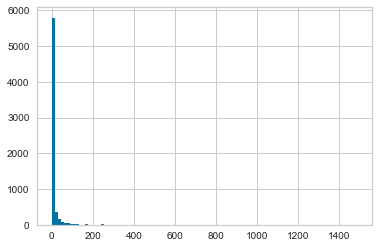

In [80]:
BoW_count.nb_tok.hist(bins=100)



In [81]:
BoW_count.describe()



nb_tok
count  6697.000000
mean     15.475138
std      67.437953
min       1.000000
25%       1.000000
50%       2.000000
75%       7.000000
max    1482.000000

In [82]:
BoW_count[BoW_count['nb_tok'] > 700].sort_values(by='nb_tok')



token   count  nb_tok
5353       set   [705]   705.0
4370      pack   [710]   710.0
3173        in   [720]   720.0
2600       for   [740]   740.0
4028       mug   [745]   745.0
6653       yes   [753]   753.0
5236     sales   [808]   808.0
1084     brand   [839]   839.0
4759   product   [953]   953.0
6442  warranty   [971]   971.0
3796  material  [1047]  1047.0
4216    number  [1051]  1051.0
3952     model  [1057]  1057.0
1444        cm  [1061]  1061.0
4241        of  [1066]  1066.0
4371   package  [1076]  1076.0
1491     color  [1214]  1214.0
6210      type  [1482]  1482.0

    Au dela de 745 (70%) occurences, il s'agit de stopwords spécifiques au corpus. En dessous de 745 occurrences, on voit apparaitre des termes de description (mug, pack)

In [83]:
BoW_count[BoW_count['nb_tok'] > 745]



token   count  nb_tok
1084     brand   [839]   839.0
1444        cm  [1061]  1061.0
1491     color  [1214]  1214.0
3796  material  [1047]  1047.0
3952     model  [1057]  1057.0
4216    number  [1051]  1051.0
4241        of  [1066]  1066.0
4371   package  [1076]  1076.0
4759   product   [953]   953.0
5236     sales   [808]   808.0
6210      type  [1482]  1482.0
6442  warranty   [971]   971.0
6653       yes   [753]   753.0

##### Tokens peu fréquents

<AxesSubplot:>

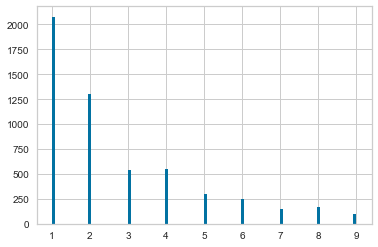

In [84]:
BoW_count[BoW_count['nb_tok'] < 10].nb_tok.hist(bins=100)



 Les occurences 1 et 2 ne serviront pas vraiment pour la catégorisation

In [85]:
BoW_count[BoW_count['nb_tok'] < 3]



token count  nb_tok
0             001   [2]     2.0
1             006   [1]     1.0
2              01   [2]     2.0
3          014311   [1]     1.0
4       01433cmgy   [1]     1.0
...           ...   ...     ...
6687         zinc   [2]     2.0
6689          zip   [2]     2.0
6690  zipexterior   [1]     1.0
6692     zippered   [1]     1.0
6694         zoom   [2]     2.0

[3376 rows x 3 columns]

#### Recalcule du BoW avec paramètres min_df et max_df

In [86]:
# min_df = permet de fixer le nb occurrence minimal du token. Ici doit être > 3
# max_df = permet de fixer le nb occurences maximales du token, ici 745
vectorizer = CountVectorizer(min_df=3, max_df=250)
X = vectorizer.fit_transform(corpus_BoW)

unique_tokens = np.array(vectorizer.get_feature_names_out())
count_tokens = np.array(X.sum(axis=0).T)

BoW2_count = pd.DataFrame([unique_tokens, count_tokens],
                          index=['token', 'count']).T
for ligne in range(BoW2_count.shape[0]):
    BoW2_count.loc[ligne, 'nb_tok'] = BoW2_count.loc[ligne, 'count'][0]

BoW2_count.describe()



nb_tok
count  1932.000000
mean     34.019151
std      64.487881
min       3.000000
25%       7.000000
50%      13.000000
75%      32.000000
max     745.000000

<AxesSubplot:>

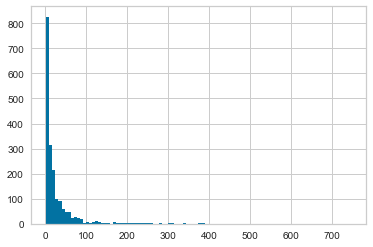

In [87]:
BoW2_count.nb_tok.hist(bins=100)



<AxesSubplot:>

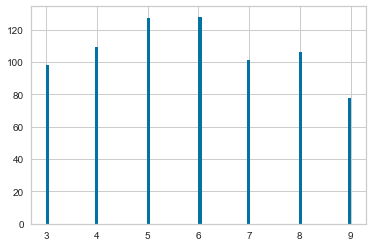

In [88]:
BoW2_count[BoW2_count['nb_tok'] < 10].nb_tok.hist(bins=100)



In [89]:
BoW2_count[BoW2_count['nb_tok'] > 600]



token  count  nb_tok
1158   mug  [745]   745.0
1543   set  [705]   705.0

#### Réduction de dimension : PCA

In [90]:
# densification de X
X_dense = np.array(X.todense())



In [91]:
n_comp = 500
pca = PCA(n_components=n_comp, random_state=0)
pca.fit(X_dense)
pca



PCA(n_components=500, random_state=0)

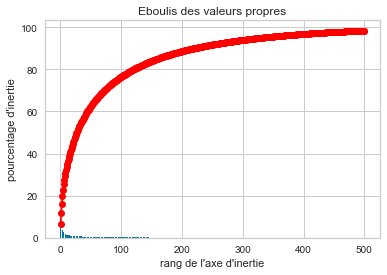

In [92]:
# Eboulis des valeurs propres
fct.display_scree_plot(pca)



In [93]:
# critere de Kaiser
explained_variance = 0
for rang in range(n_comp):
    explained_variance += pca.explained_variance_ratio_[rang]
    if pca.explained_variance_ratio_[rang] < 1/n_comp:
        print("Il y a {} rangs d'inertie qui présentent un ratio".format(rang),
              "de variance supérieur à 1/n_comp = {:0.1f}%".format(
                  100 / n_comp),
              "=> {:.2f}% de la variance totale est expliquée".format(100 * explained_variance))
        break



Il y a 99 rangs d'inertie qui présentent un ratio de variance supérieur à 1/n_comp = 0.2% => 76.37% de la variance totale est expliquée


    D'après l'éboulis des valeurs propres (critère du coude) + le critère de kaiser, il est raisonnable de réduire la dimension à 100 variables, ce qui va expliquer environ 70% des variance totale des données.

    Une autre option est de choisir de concerver suffisement de variables pour expliquer 99% de la variances totale

In [94]:
X_transformed = reduction_dimension(X_dense)


Réduction de dimension : ACP
Dimensions dataset avant réduction PCA :  (1050, 1932)
Dimensions dataset après réduction PCA :  (1050, 560)


#### investigation clustering (kmeans)

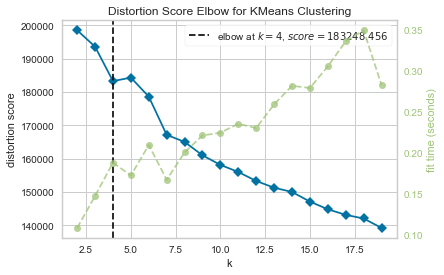

Temps d'exécution : 5.06s


In [95]:
start = timeit.default_timer()
# Instantiate the clustering model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, 20))

visualizer.fit(X_transformed)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

duree = fct.Affichage_duree(start)



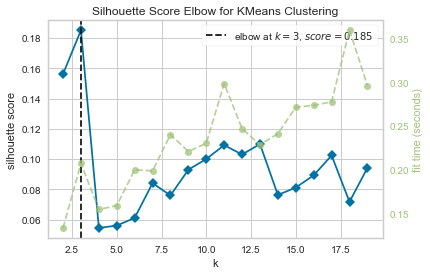

Temps d'exécution : 5.28s


In [96]:
start = timeit.default_timer()

# Instantiate the clustering model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, 20), metric='silhouette')

visualizer.fit(X_transformed)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

duree = fct.Affichage_duree(start)



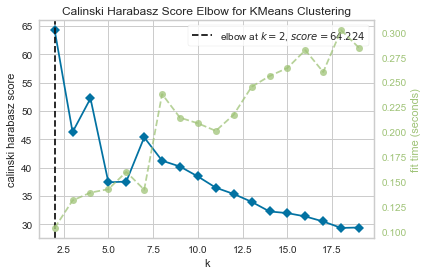

Temps d'exécution : 4.29s


In [97]:
start = timeit.default_timer()

# Instantiate the clustering model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, 20), metric='calinski_harabasz')

visualizer.fit(X_transformed)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

duree = fct.Affichage_duree(start)



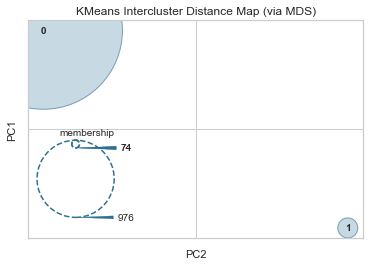

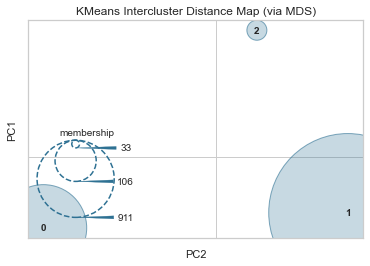

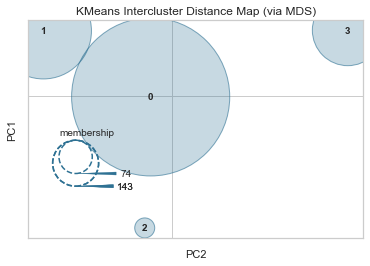

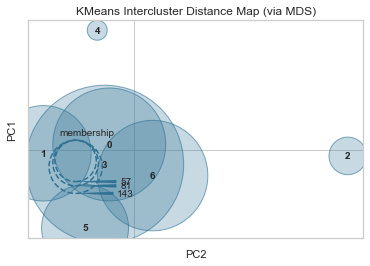

Temps d'exécution : 1.42s


In [98]:
liste_k = [2, 3, 4, 7]
start = timeit.default_timer()
for k in liste_k:
    # Instantiate the clustering model and visualizer
    model = KMeans(n_clusters=k, random_state=0)
    visualizer = InterclusterDistance(model)

    visualizer.fit(X_transformed)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure
duree = fct.Affichage_duree(start)



 Il n'y a pas vraiment de k qui ressort avec cette analyse.

#### Choix clustering
    pour pouvoir comparer aux catégories indiquées par les vendeurs je fixe k = 7

In [99]:
y_pred_BoW, ARI_BoW = clustering_7classes(X=X_transformed, labels=labels)


ARI : 0.257


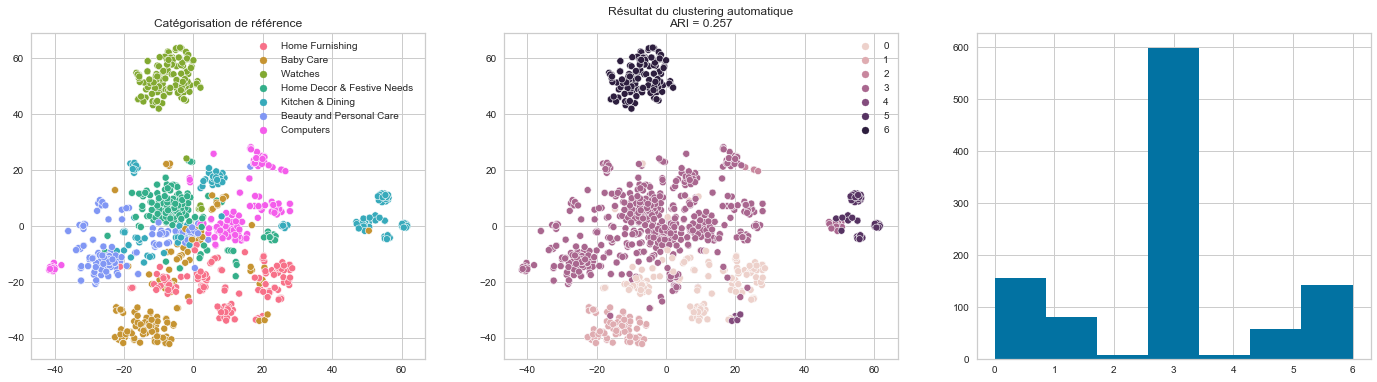

In [100]:
visu_resultats(features=X_transformed, y_pred=y_pred_BoW, ARI=ARI_BoW)


Correspondance des clusters :  [4 0 2 1 0 5 6]
              precision    recall  f1-score   support

           0       0.97      0.57      0.71       150
           1       0.25      0.99      0.40       150
           2       1.00      0.05      0.10       150
           3       0.00      0.00      0.00       150
           4       0.76      0.79      0.78       150
           5       0.98      0.37      0.54       150
           6       1.00      0.95      0.98       150

    accuracy                           0.53      1050
   macro avg       0.71      0.53      0.50      1050
weighted avg       0.71      0.53      0.50      1050



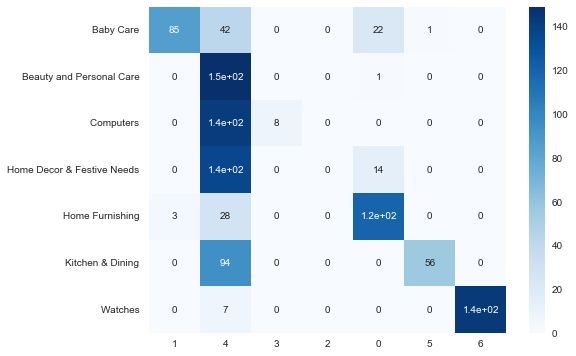

In [101]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_BoW)


 ## BoW sans nettoyage tokens

In [102]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_BoW)

unique_tokens = np.array(vectorizer.get_feature_names_out())
count_tokens = np.array(X.sum(axis=0).T)

BoW2_count = pd.DataFrame([unique_tokens, count_tokens],
                          index=['token', 'count']).T
for ligne in range(BoW2_count.shape[0]):
    BoW2_count.loc[ligne, 'nb_tok'] = BoW2_count.loc[ligne, 'count'][0]

BoW2_count.describe()


nb_tok
count  6697.000000
mean     15.475138
std      67.437953
min       1.000000
25%       1.000000
50%       2.000000
75%       7.000000
max    1482.000000

In [103]:
# densification de X
X_dense = np.array(X.todense())
X_transformed = reduction_dimension(X_dense)


Réduction de dimension : ACP
Dimensions dataset avant réduction PCA :  (1050, 6697)
Dimensions dataset après réduction PCA :  (1050, 732)


ARI : 0.216
Correspondance des clusters :  [1 0 4 5 2 2 6]
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       150
           1       0.82      0.09      0.17       150
           2       0.86      0.61      0.71       150
           3       0.00      0.00      0.00       150
           4       0.24      1.00      0.39       150
           5       0.99      0.49      0.65       150
           6       1.00      0.95      0.98       150

    accuracy                           0.53      1050
   macro avg       0.70      0.53      0.52      1050
weighted avg       0.70      0.53      0.52      1050



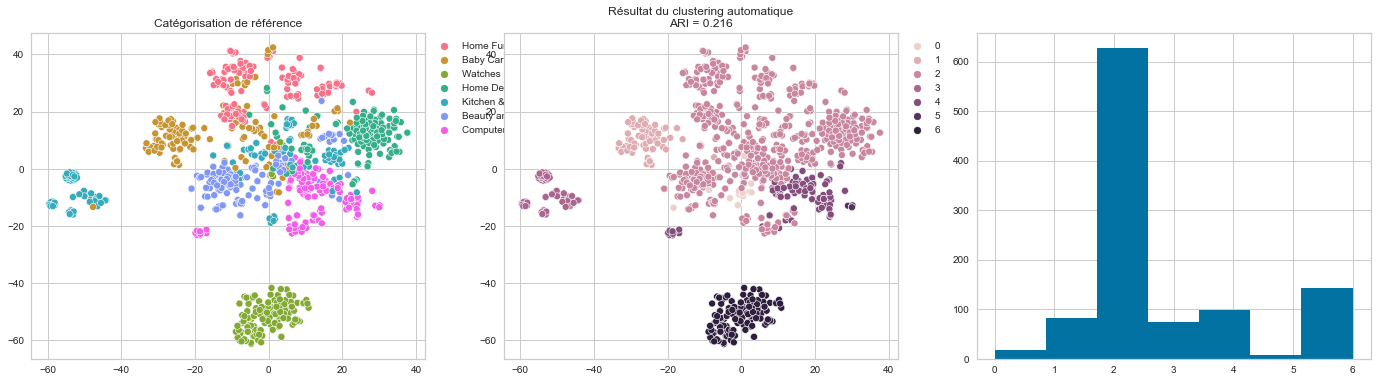

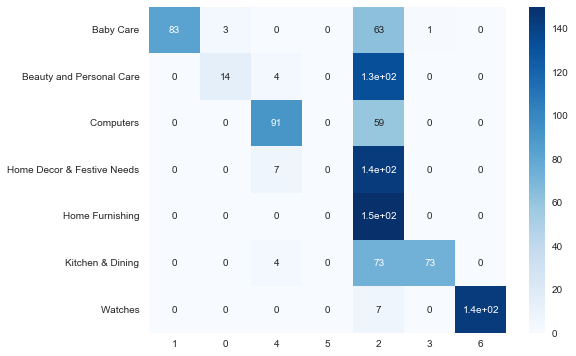

In [104]:
y_pred_BoW, ARI_BoW = clustering_7classes(X=X_transformed, labels=labels)
visu_resultats(features=X_transformed, y_pred=y_pred_BoW, ARI=ARI_BoW)
erreur_attribution(y_true=labels_int, y_pred=y_pred_BoW)


### TF-IDF

In [105]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus_BoW)
X



<1050x6697 sparse matrix of type '<class 'numpy.float64'>'
	with 57785 stored elements in Compressed Sparse Row format>

#### Réduction de dimensions : ACP

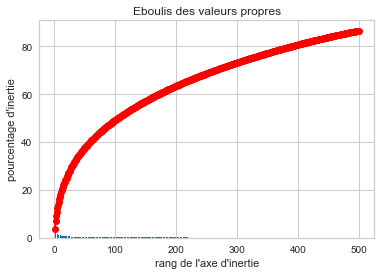

In [106]:
# densification de X
X_dense = np.array(X.todense())

n_comp = 500
pca = PCA(n_components=n_comp, random_state=0)
pca.fit(X_dense)

# Eboulis des valeurs propres
fct.display_scree_plot(pca)



In [107]:
# critere de Kaiser
explained_variance = 0
for rang in range(n_comp):
    explained_variance += pca.explained_variance_ratio_[rang]
    if pca.explained_variance_ratio_[rang] < 1/n_comp:
        print("Il y a {} rangs d'inertie qui présentent un ratio".format(rang),
              "de variance supérieur à 1/n_comp = {:0.1f}%".format(
                  100 / n_comp),
              "=> {:.2f}% de la variance totale est expliquée".format(100 * explained_variance))
        break



Il y a 88 rangs d'inertie qui présentent un ratio de variance supérieur à 1/n_comp = 0.2% => 47.10% de la variance totale est expliquée


    ça n'explique pas suffisemment de la variabilité totale => je décide de prendre toutes les features permettant d'expliquer 99% de la variance

In [108]:
x_transformed = reduction_dimension(X_dense)


Réduction de dimension : ACP
Dimensions dataset avant réduction PCA :  (1050, 6697)
Dimensions dataset après réduction PCA :  (1050, 863)


#### clustering

ARI : 0.428


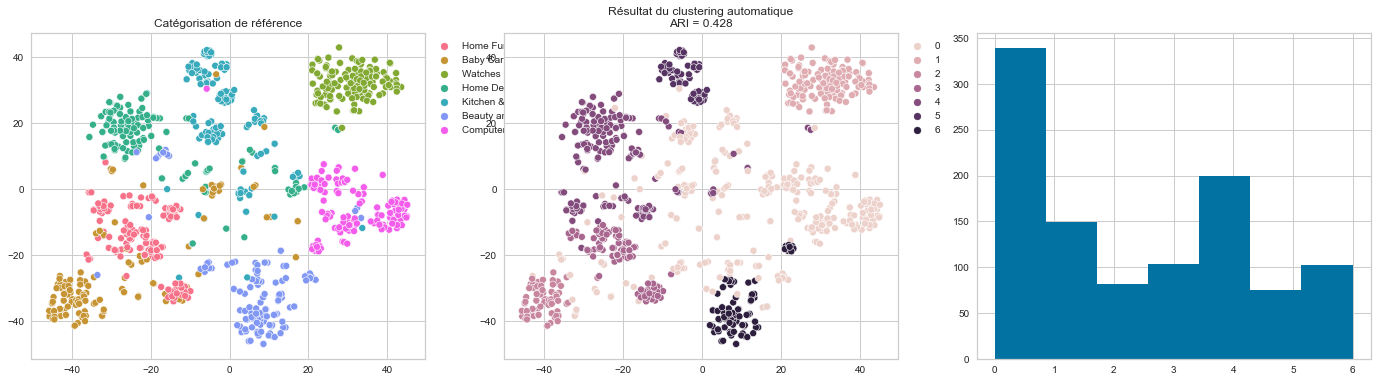

In [109]:
y_pred_tfidf, ARI_tfidf = clustering_7classes(X=x_transformed, labels=labels)
visu_resultats(features=x_transformed, y_pred=y_pred_tfidf, ARI=ARI_tfidf)


Correspondance des clusters :  [2 6 0 4 3 5 1]
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       150
           1       0.89      0.61      0.72       150
           2       0.41      0.93      0.57       150
           3       0.58      0.77      0.66       150
           4       0.80      0.55      0.65       150
           5       0.99      0.49      0.66       150
           6       1.00      0.99      1.00       150

    accuracy                           0.70      1050
   macro avg       0.81      0.70      0.71      1050
weighted avg       0.81      0.70      0.71      1050



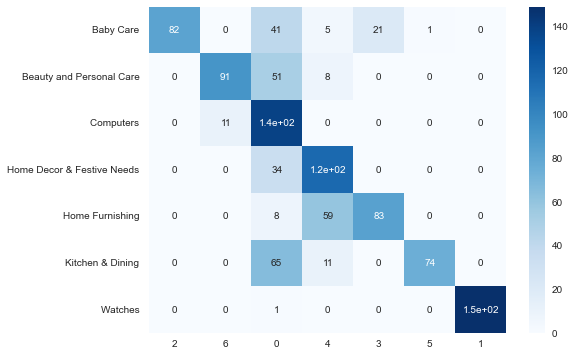

In [110]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_tfidf)


### Word2Vec

## Création du modèle word2vec

In [111]:
corpus = list(corpus)
len(corpus)



1050

In [112]:


def W2v_creation(corpus, w2v_size, w2v_window, w2v_min_count, sg_values=0):
    # Construction du modèle Word2Vec
    print("Build & train Word2Vec model ...")
    w2v_model = Word2Vec(min_count=w2v_min_count,
                         window=w2v_window,
                         vector_size=w2v_size,
                         sg=sg_values,
                         seed=0)

    w2v_model.build_vocab(corpus)
    w2v_model.train(corpus,
                    total_examples=w2v_model.corpus_count,
                    epochs=w2v_model.epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    print("Vocabulary size: %i" % len(w2v_words))
    print("Word2Vec trained")

    # Préparation des sentences (tokenization)
    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(corpus),
                                padding='post')
    num_words = len(tokenizer.word_index) + 1
    maxlen = len(x_sentences[0])
    print("Number of unique words: %i" % num_words)

    # création de la matrice d'embedding
    print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i = 0
    j = 0

    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i, 4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix: %s" % str(embedding_matrix.shape))

    # création du modèle d'embedding
    print(" Create Embedding model ...")
    input = Input(shape=(len(x_sentences), maxlen),
                  dtype='float64')
    word_input = Input(shape=(maxlen,),
                       dtype='float64')
    word_input = Input(shape=(maxlen,),
                       dtype='float64')

    word_embedding = Embedding(input_dim=vocab_size,
                               output_dim=w2v_size,
                               weights=[embedding_matrix],
                               input_length=maxlen)(word_input)

    word_vec = GlobalAveragePooling1D()(word_embedding)
    embed_model = Model([word_input], word_vec)

    # embed_model.summary()

    # Exécution du modèle
    print("Model execution ...")
    X_embedding = embed_model.predict(x_sentences)
    print("... Complete")

    return X_embedding



In [113]:
# paramètres du word2Vec :
w2v_size = 300
w2v_window = 5
w2v_min_count = 1



In [114]:
X_embedding = W2v_creation(corpus=corpus, w2v_size=w2v_size,
                           w2v_window=w2v_window, w2v_min_count=w2v_min_count)


Build & train Word2Vec model ...
Vocabulary size: 8823
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 8824
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (8824, 300)
 Create Embedding model ...
Model execution ...
... Complete


ARI : 0.194
Correspondance des clusters :  [4 6 1 5 3 0 2]
              precision    recall  f1-score   support

           0       0.56      0.41      0.47       150
           1       0.38      0.78      0.51       150
           2       0.41      0.05      0.08       150
           3       0.27      0.57      0.36       150
           4       0.29      0.11      0.16       150
           5       0.50      0.35      0.41       150
           6       1.00      0.87      0.93       150

    accuracy                           0.45      1050
   macro avg       0.49      0.45      0.42      1050
weighted avg       0.49      0.45      0.42      1050



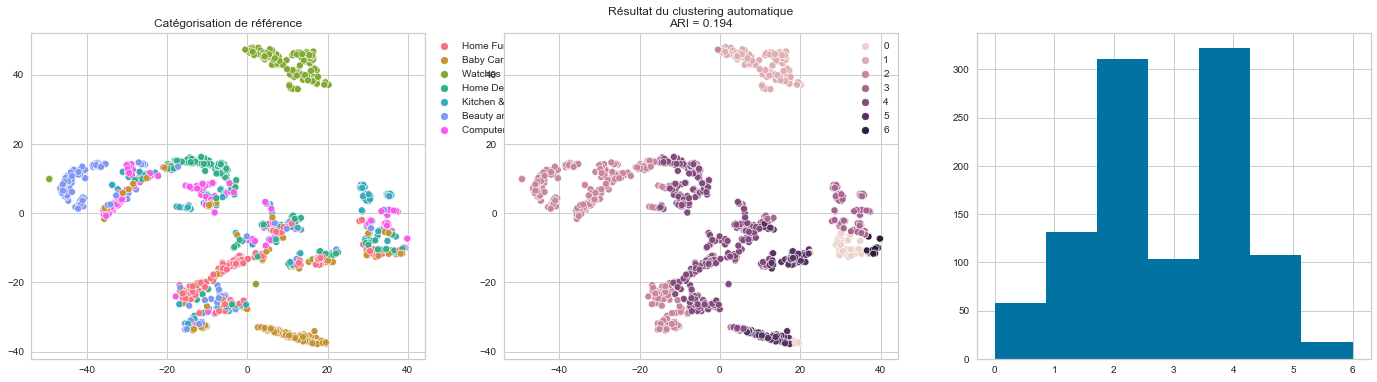

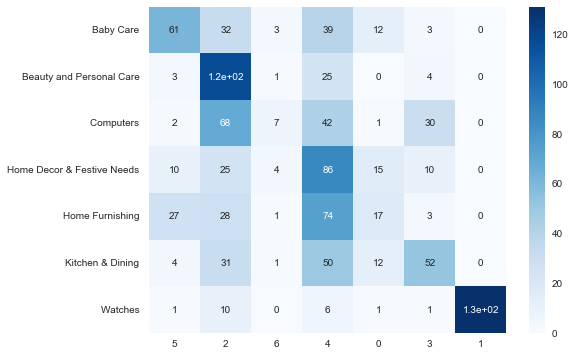

In [115]:
y_pred_W2V, ARI_W2V = clustering_7classes(X=X_embedding, labels=labels)
visu_resultats(features=X_embedding, y_pred=y_pred_W2V, ARI=ARI_W2V)
erreur_attribution(y_true=labels_int, y_pred=y_pred_W2V)


In [116]:
print("Build & train Word2Vec model ...")
w2v_model = Word2Vec(min_count=w2v_min_count,
                     window=w2v_window,
                     vector_size=w2v_size,
                     seed=0)

w2v_model.build_vocab(corpus)
w2v_model.train(corpus,
                total_examples=w2v_model.corpus_count,
                epochs=w2v_model.epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key

print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")



Build & train Word2Vec model ...
Vocabulary size: 8823
Word2Vec trained


In [117]:
w2v_model.wv.most_similar('mug')



[('coffee', 0.9790099263191223),
 ('coffeetea', 0.9624341130256653),
 ('forget', 0.9542632699012756),
 ('fantastic', 0.9522092938423157),
 ('huge', 0.947792649269104),
 ('share', 0.9477567076683044),
 ('ink', 0.9436570405960083),
 ('perfect', 0.943323016166687),
 ('give', 0.9416649341583252),
 ('ceramic', 0.9380137920379639)]

In [118]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(corpus),
                            # maxlen=maxlen,
                            padding='post')
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)



Fit Tokenizer ...
Number of unique words: 8824


In [119]:
maxlen = len(x_sentences[0])



## Création de la matrice d'embedding

In [120]:
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))



Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (8824, 300)


## Création du modèle d'embedding

In [121]:
input = Input(shape=(len(x_sentences), maxlen),
              dtype='float64')
word_input = Input(shape=(maxlen,),
                   dtype='float64')
# word_input = Input(shape=(maxlen,),
#                    dtype='float64')

word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)

word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()



Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 431)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 431, 300)          2647200   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
Total params: 2,647,200
Trainable params: 2,647,200
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [122]:
X_embedding = embed_model.predict(x_sentences)
X_embedding.shape



(1050, 300)

ARI : 0.206


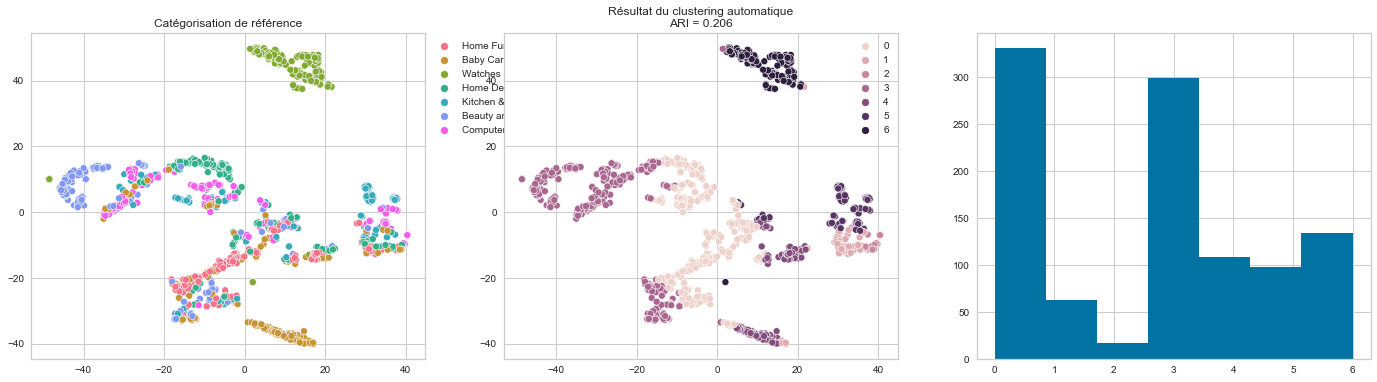

In [123]:
y_pred_W2V, ARI_W2V = clustering_7classes(X=X_embedding, labels=labels)
visu_resultats(features=X_embedding, y_pred=y_pred_W2V, ARI=ARI_W2V)


Correspondance des clusters :  [3 3 2 1 0 5 6]
              precision    recall  f1-score   support

           0       0.56      0.41      0.47       150
           1       0.39      0.78      0.52       150
           2       0.41      0.05      0.08       150
           3       0.27      0.72      0.40       150
           4       0.00      0.00      0.00       150
           5       0.51      0.33      0.40       150
           6       1.00      0.89      0.94       150

    accuracy                           0.45      1050
   macro avg       0.45      0.45      0.40      1050
weighted avg       0.45      0.45      0.40      1050



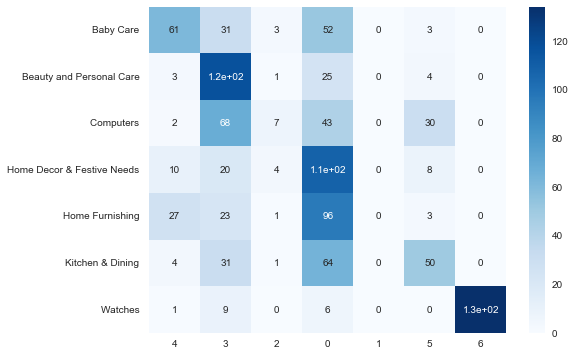

In [124]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_W2V)


## Test de différentes tailles de vecteurs

----------
Taille vecteur =  50
Build & train Word2Vec model ...
Vocabulary size: 8823
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 8824
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (8824, 50)
 Create Embedding model ...
Model execution ...
... Complete
ARI : 0.209
Correspondance des clusters :  [0 5 2 3 1 6 3]
              precision    recall  f1-score   support

           0       0.60      0.45      0.51       150
           1       0.39      0.78      0.52       150
           2       0.39      0.05      0.08       150
           3       0.27      0.75      0.40       150
           4       0.00      0.00      0.00       150
           5       0.70      0.33      0.45       150
           6       1.00      0.90      0.95       150

    accuracy                           0.46      1050
   macro avg       0.48      0.46      0.42      1050
weighted avg       0.48      0.46      0.42      1050

----------
Taille vecteur =  100
Build & train W

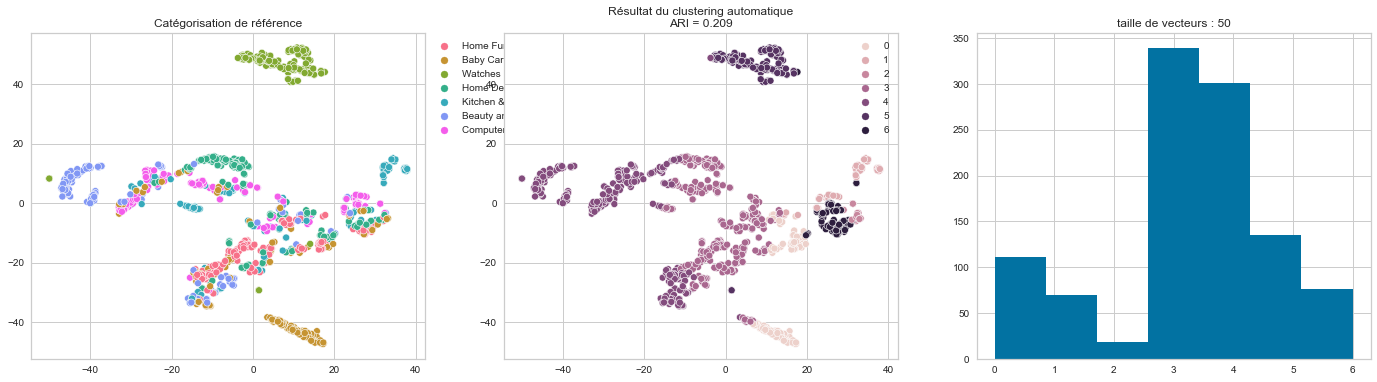

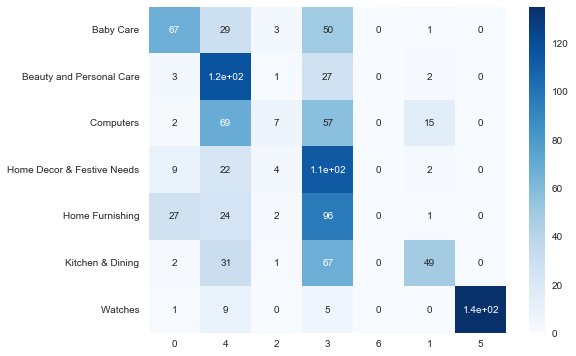

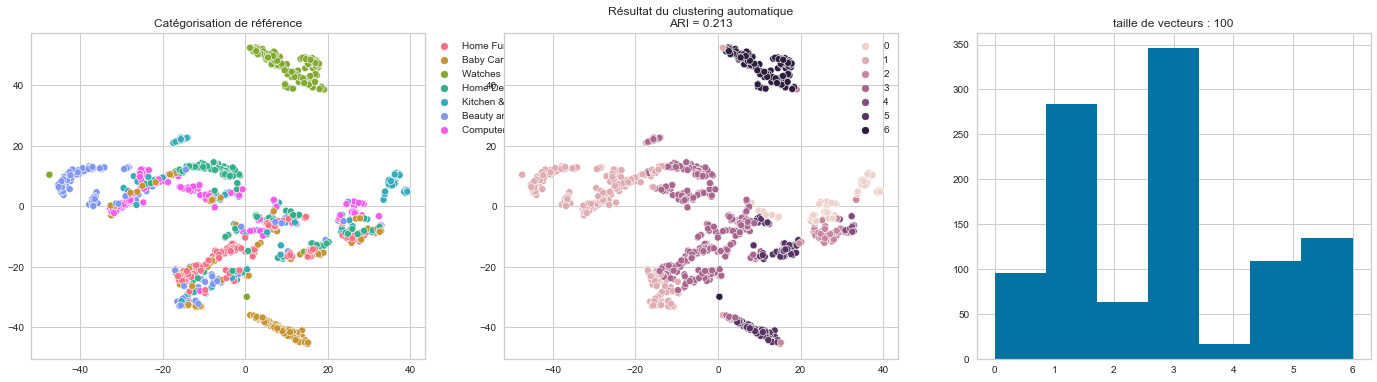

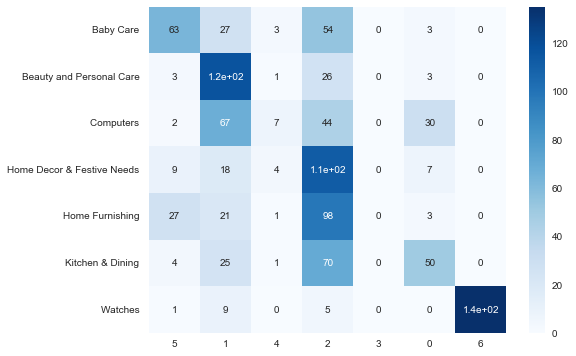

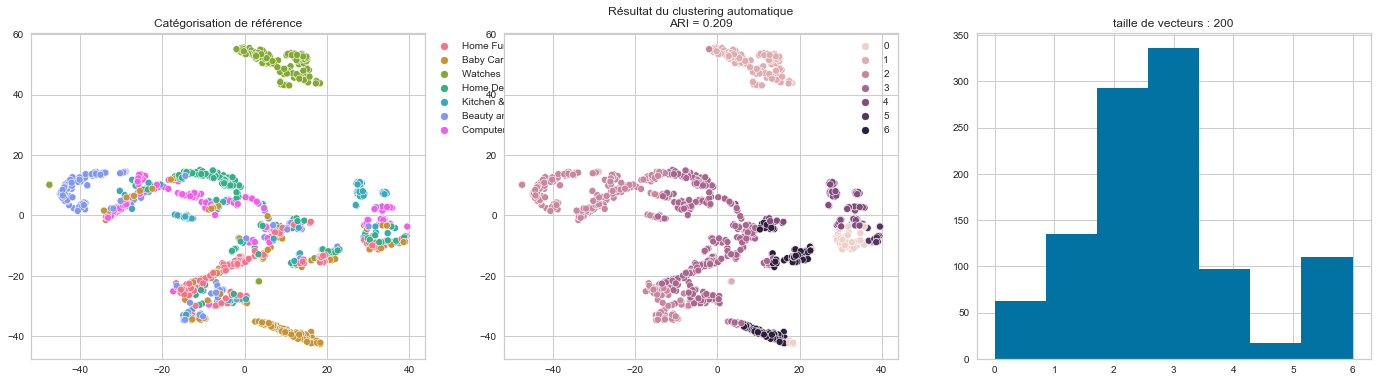

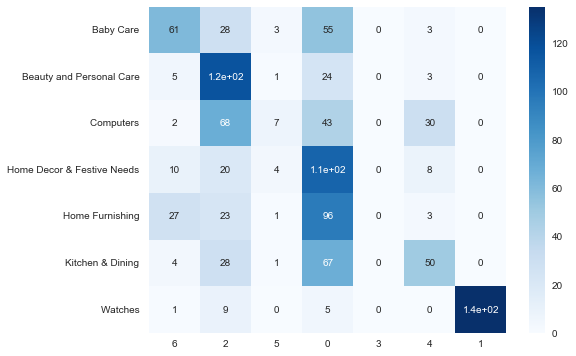

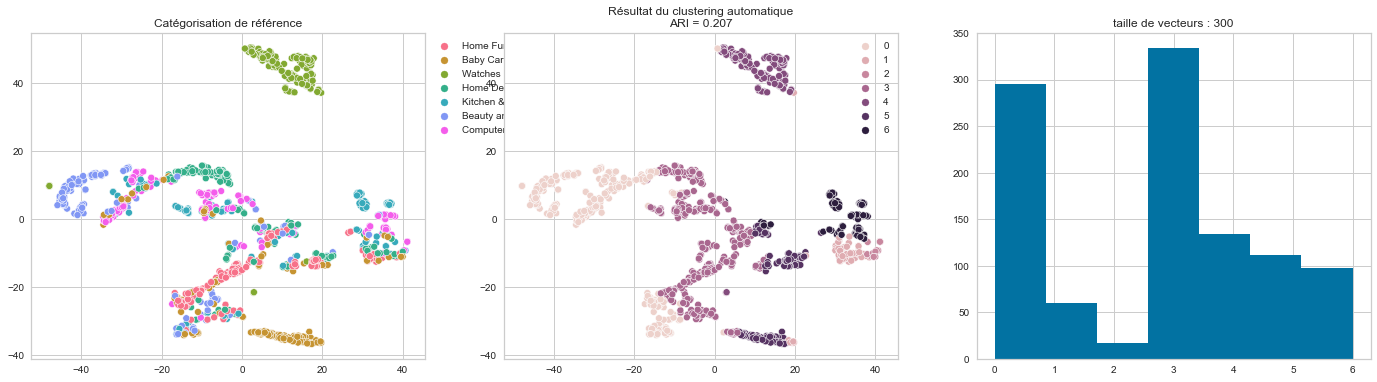

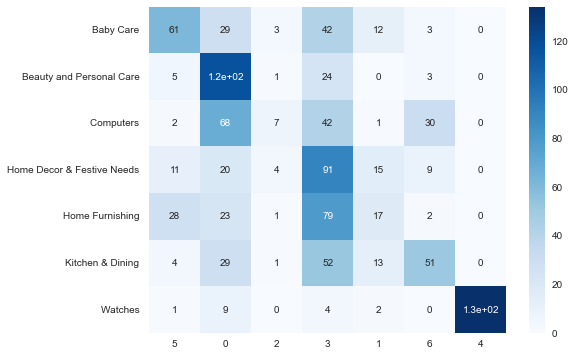

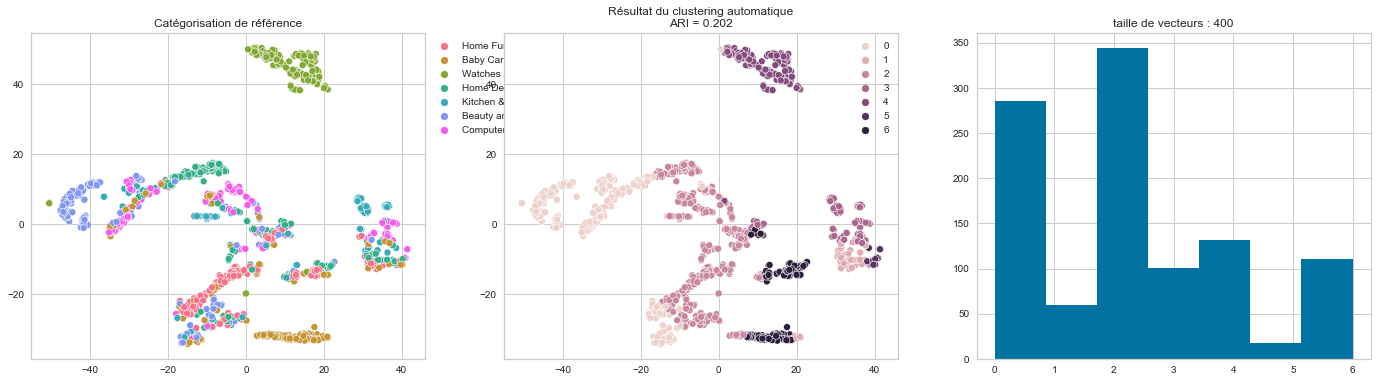

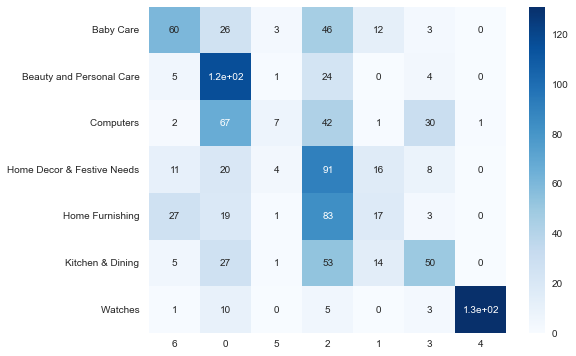

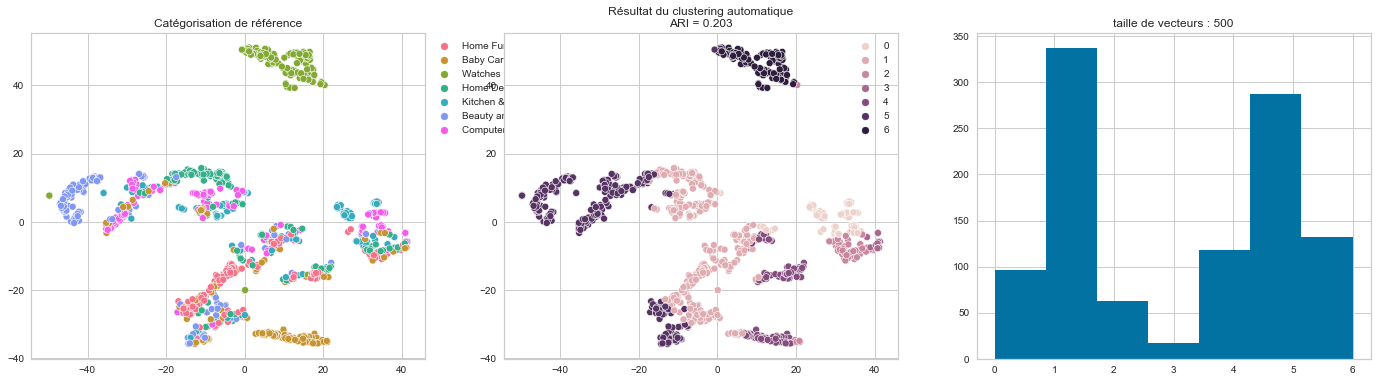

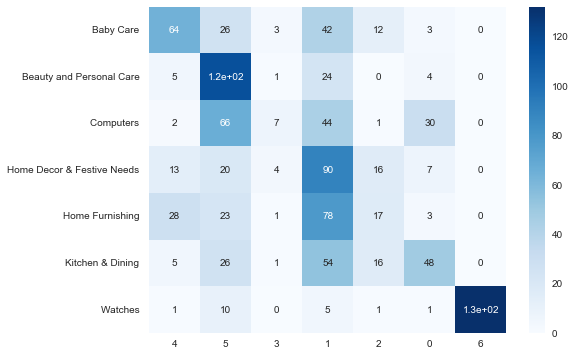

In [125]:
sizes = [50, 100, 200, 300, 400, 500]
for size in sizes:
    print("-"*10)
    print("Taille vecteur = ", size)
    X_embedding = W2v_creation(corpus=corpus,
                               w2v_size=size,
                               w2v_window=5,
                               w2v_min_count=1)
    y_pred_W2V, ARI_W2V = clustering_7classes(X=X_embedding, labels=labels)
    visu_resultats(features=X_embedding, y_pred=y_pred_W2V, ARI=ARI_W2V)
    plt.title('taille de vecteurs : {}'.format(size))
    erreur_attribution(y_true=labels_int, y_pred=y_pred_W2V)



 ## Test algo skip-gram vs cbow

In [126]:
size = 200


----------
algo CBOW
Build & train Word2Vec model ...
Vocabulary size: 8823
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 8824
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (8824, 200)
 Create Embedding model ...
Model execution ...
... Complete
ARI : 0.208
Correspondance des clusters :  [4 1 0 3 6 5 2]
              precision    recall  f1-score   support

           0       0.55      0.41      0.47       150
           1       0.40      0.77      0.52       150
           2       0.41      0.05      0.08       150
           3       0.27      0.61      0.38       150
           4       0.29      0.11      0.16       150
           5       0.51      0.35      0.41       150
           6       1.00      0.89      0.94       150

    accuracy                           0.46      1050
   macro avg       0.49      0.46      0.43      1050
weighted avg       0.49      0.46      0.43      1050

----------
algo skip-gram
Build & train Word2Vec model ...

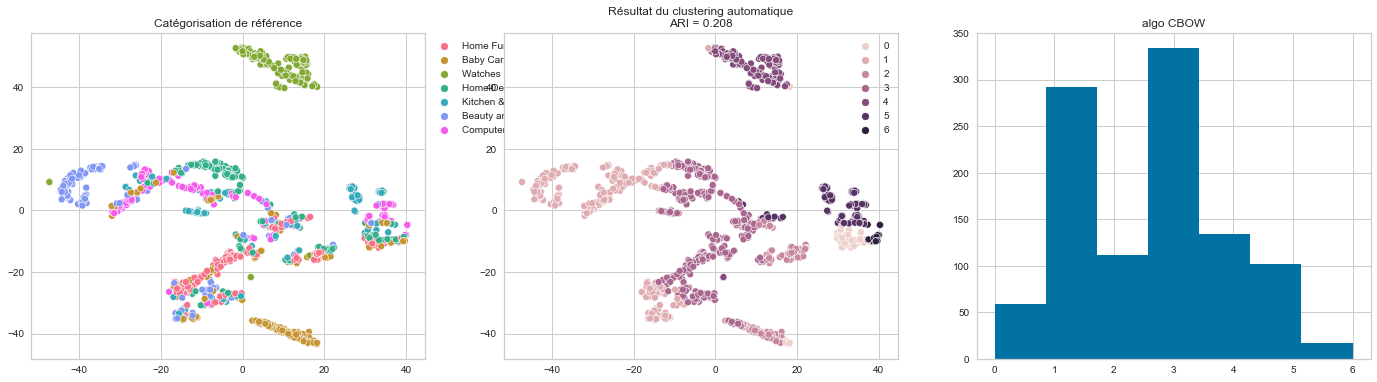

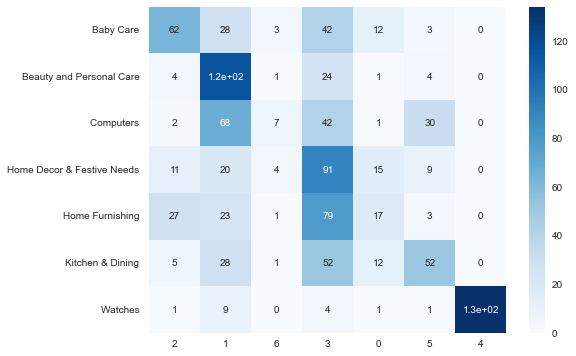

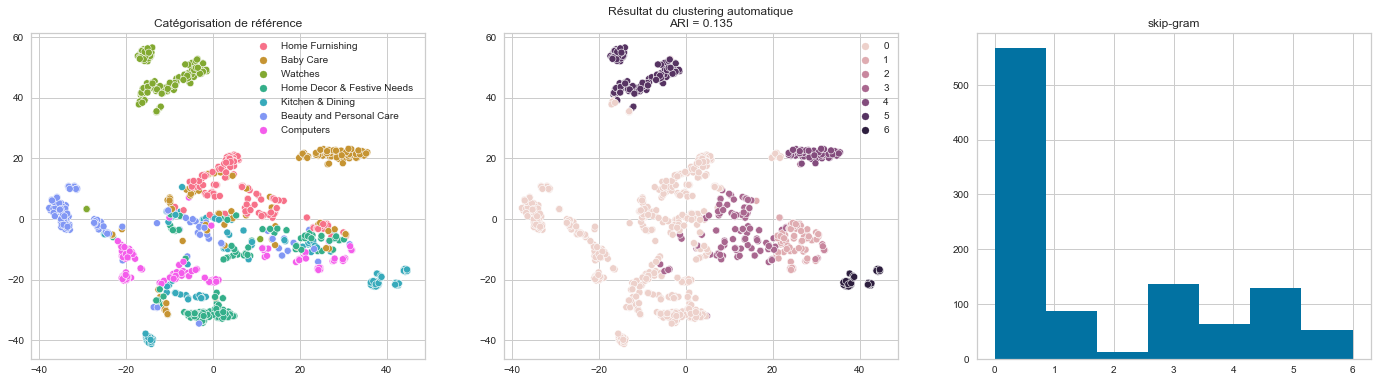

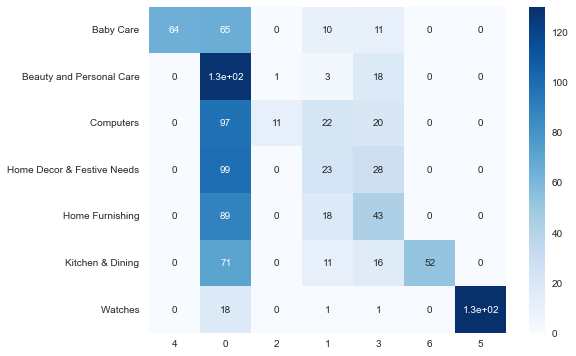

In [127]:
sg_values = [0, 1]
for sg_val in sg_values:
    print("-"*10)
    if sg_val == 0:
        print('algo CBOW')
    else:
        print('algo skip-gram')
    X_embedding = W2v_creation(corpus=corpus,
                               w2v_size=size,
                               w2v_window=5,
                               w2v_min_count=1,
                               sg_values=sg_val)
    y_pred_W2V, ARI_W2V = clustering_7classes(X=X_embedding, labels=labels)
    visu_resultats(features=X_embedding, y_pred=y_pred_W2V, ARI=ARI_W2V)
    if sg_val == 0:
        plt.title('algo CBOW')
    else:
        plt.title('skip-gram')
    erreur_attribution(y_true=labels_int, y_pred=y_pred_W2V)


 Les résultats du Word2Vec donne des résultats moins bon que tf-idf

   # Utilisation de BERT

In [128]:


# Bert
# from transformers import *

os.environ["TF_KERAS"] = '1'



In [129]:
print("tf:", tf.__version__)
print("tensorflow:", tensorflow.__version__)
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
print("transformers:", transformers.__version__)



tf: 2.3.0
tensorflow: 2.3.0
Num GPUs Available:  0
transformers: 4.17.0


In [130]:
# Fonction de préparation des sentences


def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
        # print(bert_inp['attention_mask'])

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot



In [131]:
# Fonction de création des features


def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in tqdm(range(len(sentences)//batch_size)):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                               bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot, attention_mask



   ## Bert-uncased

   Ne fonctionne pas avec des phrases qui font plus de 512 caractères (ce qui est le cas ici, on va jusqu'à plus de 2000 caractères quand on regroupe les info de la colonne description + spec')

   ==> je pars uniquement sur la colonne description + suppression des tokens apparaissant moins de 5 fois ou plus de 450 fois

In [132]:
corpus_description = vect_data_lemma['description_lemmatized']

corpus_bert = []
for liste in corpus_description:
    corpus_bert.append(make_sentence(liste))
corpus_bert



['key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look interiorsthis curtain made high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimension length cm box nu

<AxesSubplot:>

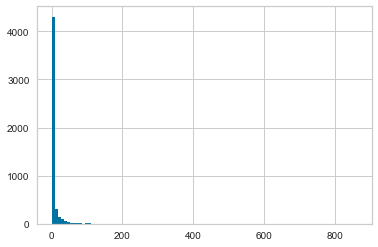

In [133]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_bert)

unique_tokens = np.array(vectorizer.get_feature_names_out())
count_tokens = np.array(X.sum(axis=0).T)
bert_count = pd.DataFrame([unique_tokens, count_tokens],
                          index=['token', 'count']).T
for ligne in range(bert_count.shape[0]):
    bert_count.loc[ligne, 'nb_tok'] = bert_count.loc[ligne, 'count'][0]
bert_count.nb_tok.hist(bins=100)



In [134]:
# token qui correspondent à des stop words => a supprimer
bert_count[bert_count['nb_tok'] > 450].sort_values(by='nb_tok')



token  count  nb_tok
2017    guarantee  [471]   471.0
1749  flipkartcom  [472]   472.0
1145          day  [552]   552.0
3514        price  [559]   559.0
3768  replacement  [559]   559.0
687          cash  [564]   564.0
1895      genuine  [564]   564.0
4085     shipping  [564]   564.0
830            cm  [567]   567.0
1187     delivery  [567]   567.0
613           buy  [581]   581.0
1808         free  [612]   612.0
3544      product  [861]   861.0

<AxesSubplot:>

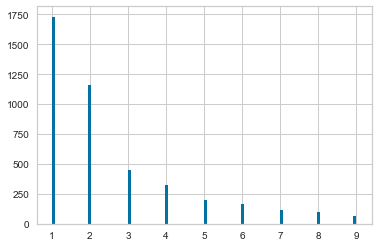

In [135]:
bert_count[bert_count['nb_tok'] < 10].nb_tok.hist(bins=100)



In [136]:
# De nombreux tokens apparaissent moins de 5 fois
tot = len(unique_tokens)
for nb in range(1, 10):
    decompte = bert_count[bert_count['nb_tok'] == nb].shape[0]
    print("{} ({:.2f}%) tokens n'apparaissent que {} fois".format(
        decompte, 100*decompte/tot, nb))

# count_1fois = bert_count[bert_count['nb_tok'] == 1].shape[0]
# count_2fois = bert_count[bert_count['nb_tok'] == 2].shape[0]

# print("{} ({:.2f}%) tokens n'apparaissent qu'une fois".format(count_1fois, 100*count_1fois/tot))
# print("{} ({:.2f}%) tokens n'apparaissent que 2 fois".format(count_2fois, 100*count_2fois/tot))



1730 (33.76%) tokens n'apparaissent que 1 fois
1163 (22.69%) tokens n'apparaissent que 2 fois
449 (8.76%) tokens n'apparaissent que 3 fois
325 (6.34%) tokens n'apparaissent que 4 fois
195 (3.80%) tokens n'apparaissent que 5 fois
164 (3.20%) tokens n'apparaissent que 6 fois
113 (2.20%) tokens n'apparaissent que 7 fois
96 (1.87%) tokens n'apparaissent que 8 fois
67 (1.31%) tokens n'apparaissent que 9 fois


In [137]:
stopword_bert = bert_count[bert_count['nb_tok'] < 5]['token'].tolist()
stopword_bert += bert_count[bert_count['nb_tok'] > 450]['token'].tolist()
len(stopword_bert)



3680

In [138]:


def make_sentence_bert(liste):
    sentence = " ".join([word for word in liste if word not in stopword_bert])
    return sentence



In [139]:
# suppression des tokens stopword et des tokens trop peu fréquents
corpus_description_bert = []
for text in corpus_description:
    corpus_description_bert.append(make_sentence_bert(text))
corpus_description_bert



['key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack r curtain enhances look curtain made high quality polyester feature eyelet style metal make room curtain ant anti elegant home bright appeal design attention sure heart contemporary eyelet curtain draw first morning bright sun ray want wish good morning whole world draw create special moment beauty print bring home elegant curtain light room get right elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id color multicolor dimension length box number content sale package pack sale package curtain body design material polyester',
 'specification cotton bath towel bath towel red yellow blue bath towel feature machine washable yes material cotton design self design general brand type bath towel gsm model name cotton bath towel idea

In [140]:
analyse = pd.DataFrame(corpus_description_bert)
compteur = 0
for liste in corpus_description_bert:
    analyse.loc[compteur, 'taille_sentence'] = len(liste)
    corpus_bert.append(liste)
    compteur += 1
type(corpus_bert)



list

In [141]:
analyse[analyse.taille_sentence > 512]



0  taille_sentence
0     key feature elegance polyester multicolor abst...            792.0
2     key feature eurospa cotton terry face towel se...            757.0
3     key feature santosh royal fashion cotton print...            673.0
4     key feature jaipur print cotton floral king si...            832.0
10    analogdigital watch men boy r present black di...            513.0
...                                                 ...              ...
1036  key feature print shape red laptop skin mouse ...            639.0
1038  key feature surgical e sstudio gown pant washa...            526.0
1039  key feature reiki crystal showpiece singing bo...            728.0
1045  extra large self adhesive sticker pack r doubl...            964.0
1046  wallmantra large vinyl sticker sticker pack r ...            779.0

[180 rows x 2 columns]

In [142]:
analyse.describe()



taille_sentence
count      1050.000000
mean        252.136190
std         288.010158
min           1.000000
25%          48.000000
50%         133.500000
75%         375.750000
max        1866.000000

   Il y a encore trop de lignes avec plus de 512 caracteres

   ==> wk sur la colonne product_specifications

In [143]:
vect_data_lemma.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   uniq_id                  1050 non-null   object
 1   product_name_lemmatized  1050 non-null   object
 2   product_spec_lemmatized  1050 non-null   object
 3   description_lemmatized   1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


In [144]:
corpus_spec = vect_data_lemma['product_spec_lemmatized']

corpus_bert = []
taille = []
for liste in corpus_spec:
    corpus_bert.append(make_sentence(liste))
    taille.append(len(make_sentence(liste)))
taille = pd.DataFrame(taille)
masque = taille[0] > 512
print("il y a {} spec faisant plus de 512 caracteres".format(masque.sum()))



il y a 79 spec faisant plus de 512 caracteres


<AxesSubplot:>

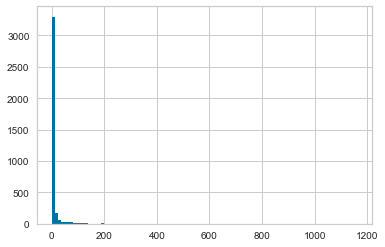

In [145]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_bert)

unique_tokens = np.array(vectorizer.get_feature_names_out())
count_tokens = np.array(X.sum(axis=0).T)
bert_count = pd.DataFrame([unique_tokens, count_tokens],
                          index=['token', 'count']).T
for ligne in range(bert_count.shape[0]):
    bert_count.loc[ligne, 'nb_tok'] = bert_count.loc[ligne, 'count'][0]
bert_count.nb_tok.hist(bins=100)



In [146]:
# token qui correspondent à des stop words => a supprimer
bert_count[bert_count['nb_tok'] > 300].sort_values(by='nb_tok')



token   count  nb_tok
1224      dial   [305]   305.0
1745    height   [308]   308.0
3625    weight   [342]   342.0
2368      name   [349]   349.0
2524      pack   [379]   379.0
979         cm   [384]   384.0
1046  contents   [414]   414.0
3651     width   [430]   430.0
3253     strap   [466]   466.0
1826     ideal   [499]   499.0
781      brand   [601]   601.0
3719       yes   [638]   638.0
1845        in   [720]   720.0
3598  warranty   [725]   725.0
2194  material   [740]   740.0
1537       for   [740]   740.0
2444    number   [801]   801.0
2525   package   [808]   808.0
2982     sales   [808]   808.0
2287     model   [837]   837.0
995      color   [844]   844.0
2455        of  [1066]  1066.0
3481      type  [1158]  1158.0

<AxesSubplot:>

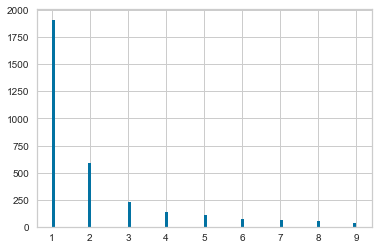

In [147]:
bert_count[bert_count['nb_tok'] < 10].nb_tok.hist(bins=100)



In [148]:
# De nombreux tokens apparaissent moins de 3 fois
tot = len(unique_tokens)
for nb in range(1, 10):
    decompte = bert_count[bert_count['nb_tok'] == nb].shape[0]
    print("{} ({:.2f}%) tokens n'apparaissent que {} fois".format(
        decompte, 100*decompte/tot, nb))



1911 (50.99%) tokens n'apparaissent que 1 fois
586 (15.64%) tokens n'apparaissent que 2 fois
229 (6.11%) tokens n'apparaissent que 3 fois
138 (3.68%) tokens n'apparaissent que 4 fois
108 (2.88%) tokens n'apparaissent que 5 fois
75 (2.00%) tokens n'apparaissent que 6 fois
63 (1.68%) tokens n'apparaissent que 7 fois
57 (1.52%) tokens n'apparaissent que 8 fois
38 (1.01%) tokens n'apparaissent que 9 fois


In [149]:
stopword_bert = bert_count[bert_count['nb_tok'] < 3]['token'].tolist()
stopword_bert += bert_count[bert_count['nb_tok'] > 300]['token'].tolist()
len(stopword_bert)



2520

In [150]:
# suppression des tokens stopword et des tokens trop peu fréquents
corpus_spec_bert = []
for text in corpus_spec:
    corpus_spec_bert.append(make_sentence_bert(text))
corpus_spec_bert



['elegance designed for door eyelet model name abstract polyester door curtain set of 2 model id multicolor length 213 cm number of contents in sales package pack of 2 sales package 2 curtains polyester',
 'machine washable cotton design self design bath towel gsm 500 model name sathiyas cotton bath towel ideal for men, women, boys, girls model id red, yellow, blue size length 30 inch 60 inch number of contents in sales package 3 sales package 3 bath towel',
 'cotton terry design gsm face towel set model name ideal for boys, girls, men, women model id size small assorted 350 g length 9 inch 9 inch number of contents in sales package 20 sales package 20 piece face towel set',
 'santosh royal fashion machine washable flat cotton model name gold design royal cotton printed wedding and gifted double bedsheet with 2 pillow cover model id multicolor size king fabric care machine wash, do not bleach flat sheet width 90 inch  fitted sheet width 228 cm pillow cover width 16 inch  pillow cover l

In [151]:
analyse = pd.DataFrame(corpus_spec_bert)
compteur = 0
corpus_bert = []
for liste in corpus_spec_bert:
    analyse.loc[compteur, 'taille_sentence'] = len(liste)
    corpus_bert.append(liste)
    compteur += 1
print("il reste {} entrées avec plus de 512 caracteres".format(
    len(analyse[analyse.taille_sentence > 512])))



il reste 62 entrées avec plus de 512 caracteres


   ==> je les supprime pour pouvoir tester l'algrithme BERT

In [152]:
corpus_bert = []
labels_bert = []
labels_int_bert = []
compteur = 0
for texte in corpus_spec_bert:
    if len(texte) < 512:
        corpus_bert.append(texte)
        labels_bert.append(labels[compteur])
        labels_int_bert.append(labels_int[compteur])
    compteur += 1
len(corpus_bert)



988

In [153]:
len(labels_bert)



988

In [154]:
labels_bert


['Home Furnishing ',
 'Baby Care ',
 'Baby Care ',
 'Home Furnishing ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Watches ',
 'Home Furnishing ',
 'Home Furnishing ',
 'Home Furnishing ',
 'Home Decor & Festive Needs ',
 'Kitchen & Dining ',
 'Kitchen & Dining ',
 'Home Furnishing ',
 'Baby Care ',
 'Home Furnishing ',
 'Baby Care ',
 'Beauty and Personal Care ',
 'Kitchen & Dining ',
 'Kitchen & Dining ',
 'Kitchen & Dining ',
 'Computers ',
 'Kitchen & Dining ',
 'Beauty and Personal Care ',
 'Kitchen & Dining ',
 'Computers ',
 'Kitchen & Dining ',
 'Computers ',
 'Computers ',
 'Computers ',
 'Beauty and Personal Care ',
 'Beauty and Personal Care ',
 'Beauty and Personal Care ',
 'Beauty and Personal Care ',
 'Beauty and Personal Care ',
 'Beauty and Personal Care ',
 'Beauty and Personal C

   ### Mise en place du modèle

In [185]:
batch_size = 4
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)
model.summary()



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [156]:
max_length = max_len
batch_size = 4
batch_size_pred = batch_size
model_type = 'bert-base-uncased'
bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
mode = 'HF'
time1 = time.time()

for step in range(len(corpus_bert)//batch_size):
    idx = step*batch_size
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in corpus_bert[idx:idx+batch_size]:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              #   max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    if mode == 'HF':    # Bert HuggingFace
        outputs = model.predict(
            [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
        last_hidden_states = outputs.last_hidden_state

    if mode == 'TFhub':  # Bert Tensorflow Hub
        text_preprocessed = {"input_word_ids": input_ids,
                             "input_mask": attention_mask,
                             "input_type_ids": token_type_ids}
        outputs = model(text_preprocessed)
        last_hidden_states = outputs['sequence_output']

    if step == 0:
        last_hidden_states_tot = last_hidden_states
        last_hidden_states_tot_0 = last_hidden_states
    else:
        last_hidden_states_tot = np.concatenate(
            (last_hidden_states_tot, last_hidden_states))

features_bert = np.array(last_hidden_states_tot).mean(axis=1)

time2 = np.round(time.time() - time1, 0)
print("temps traitement : ", time2)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [157]:
pd.DataFrame(features_bert).shape



(988, 768)

   ### Clustering

ARI : 0.523
Correspondance des clusters :  [1 0 6 1 2 3 5]
              precision    recall  f1-score   support

           0       0.47      0.84      0.61       147
           1       0.84      0.88      0.86       147
           2       0.78      0.96      0.86       125
           3       0.57      0.83      0.68       144
           4       0.00      0.00      0.00       141
           5       0.99      0.50      0.67       149
           6       0.95      0.95      0.95       135

    accuracy                           0.70       988
   macro avg       0.66      0.71      0.66       988
weighted avg       0.66      0.70      0.66       988



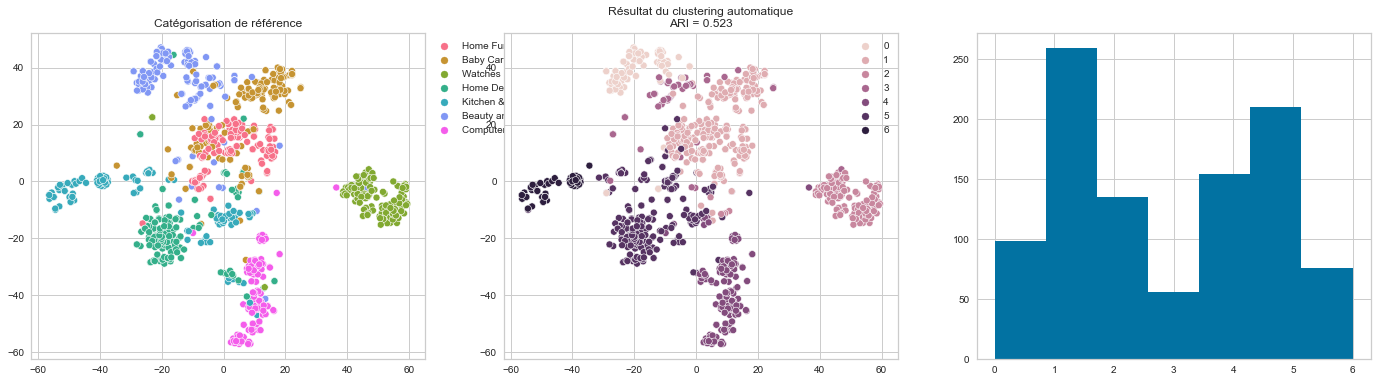

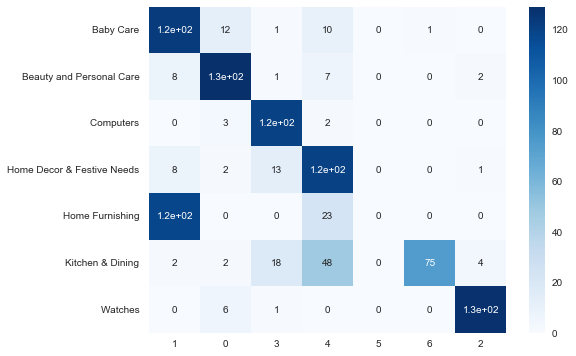

In [158]:
y_pred_bert, ARI_bert = clustering_7classes(
    X=features_bert, labels=labels_bert)
visu_resultats(features=features_bert, y_pred=y_pred_bert,
               ARI=ARI_bert, y_true=labels_bert)
erreur_attribution(y_true=labels_int_bert,
                   y_pred=y_pred_bert, labels=labels_bert)



  ### Test avec TFhub

In [159]:
# import tensorflow_text

model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)



In [160]:
model = bert_layer
# max_length = max_len
batch_size = 4
batch_size_pred = batch_size
model_type = 'bert-base-uncased'
bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
mode = 'TFhub'
time1 = time.time()

for step in range(len(corpus_bert)//batch_size):
    idx = step*batch_size
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in corpus_bert[idx:idx+batch_size]:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              #   max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    if mode == 'HF':    # Bert HuggingFace
        outputs = model.predict(
            [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
        last_hidden_states = outputs.last_hidden_state

    if mode == 'TFhub':  # Bert Tensorflow Hub
        text_preprocessed = {"input_word_ids": input_ids,
                             "input_mask": attention_mask,
                             "input_type_ids": token_type_ids}
        outputs = model(text_preprocessed)
        last_hidden_states = outputs['sequence_output']

    if step == 0:
        last_hidden_states_tot = last_hidden_states
        last_hidden_states_tot_0 = last_hidden_states
    else:
        last_hidden_states_tot = np.concatenate(
            (last_hidden_states_tot, last_hidden_states))

features_bert = np.array(last_hidden_states_tot).mean(axis=1)

time2 = np.round(time.time() - time1, 0)
print("temps traitement : ", time2)



temps traitement :  983.0


In [161]:
len(features_bert)



988

ARI : 0.523
Correspondance des clusters :  [1 0 6 1 2 3 5]
              precision    recall  f1-score   support

           0       0.47      0.84      0.61       147
           1       0.84      0.88      0.86       147
           2       0.78      0.96      0.86       125
           3       0.57      0.83      0.68       144
           4       0.00      0.00      0.00       141
           5       0.99      0.50      0.67       149
           6       0.95      0.95      0.95       135

    accuracy                           0.70       988
   macro avg       0.66      0.71      0.66       988
weighted avg       0.66      0.70      0.66       988



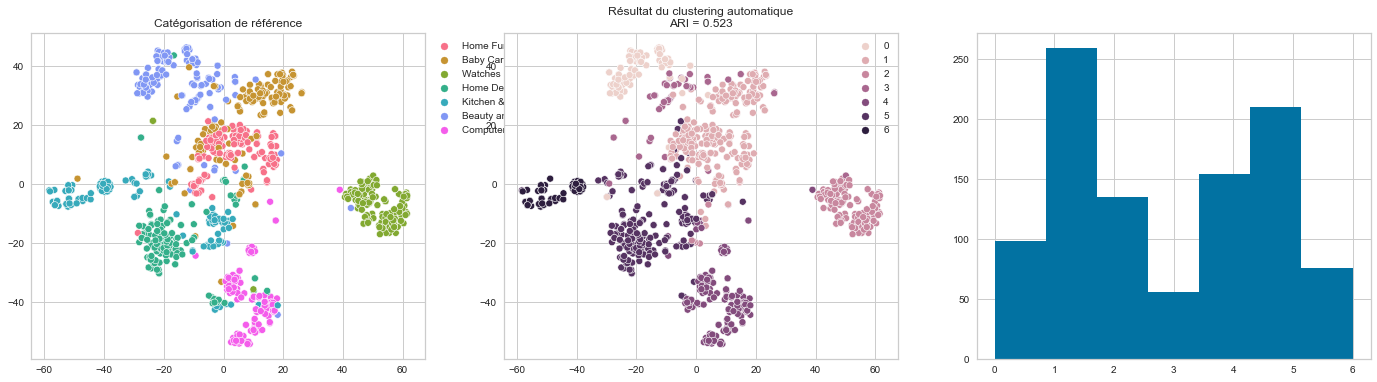

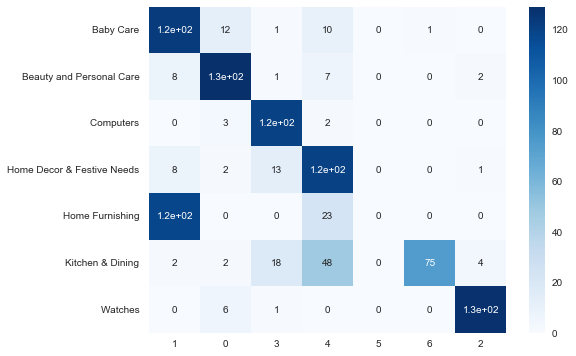

In [162]:
y_pred_bert, ARI_bert = clustering_7classes(
    X=features_bert, labels=labels_bert)
visu_resultats(features=features_bert, y_pred=y_pred_bert,
               ARI=ARI_bert, y_true=labels_bert)
erreur_attribution(y_true=labels_int_bert,
                   y_pred=y_pred_bert, labels=labels_bert)



 Score ARI interessant, par contre on voit que la catégorisation automatique a du mal à distinguer les catégories Baby care et Home Furnishing ainsi que la catégorie Kitchen & Dining qui est distribuée dans plusieurs clusters. Il faudrait regarder les produits qui sont mal catégorisés.

 Autre point délicat : la limitation du nombre de caractères en entrée (max 512) qui oblige à travailler avec uniquement une partie des données (988 images au lieu de 1050).


  # Utilisation de USE

In [165]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")



In [166]:
batch_size = 4
time1 = time.time()

for step in tqdm(range(len(corpus_bert)//batch_size)):
    idx = step*batch_size
    feat = embed(corpus_bert[idx:idx+batch_size])

    if step == 0:
        features_use = feat
    else:
        features_use = np.concatenate((features_use, feat))

time2 = np.round(time.time() - time1, 0)
print(time2)



100%|██████████| 247/247 [00:00<00:00, 290.63it/s]

1.0


In [167]:
len(features_use)



988

In [168]:
features_use.shape



(988, 512)

ARI : 0.592
Correspondance des clusters :  [3 4 2 0 6 1 5]
              precision    recall  f1-score   support

           0       0.93      0.56      0.70       147
           1       0.93      0.92      0.92       147
           2       0.90      0.74      0.81       125
           3       0.51      0.88      0.64       144
           4       0.70      0.99      0.82       141
           5       1.00      0.50      0.66       149
           6       1.00      0.96      0.98       135

    accuracy                           0.79       988
   macro avg       0.85      0.79      0.79       988
weighted avg       0.85      0.79      0.79       988



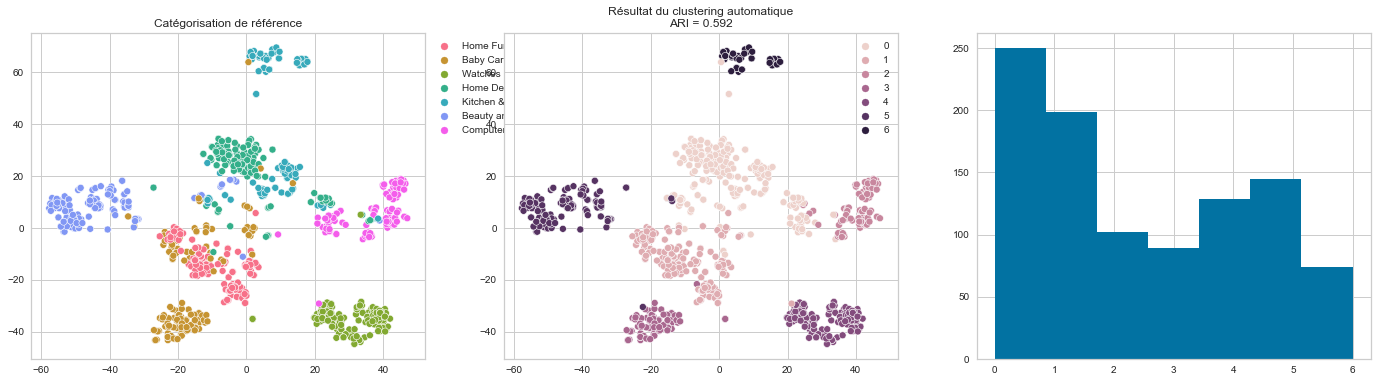

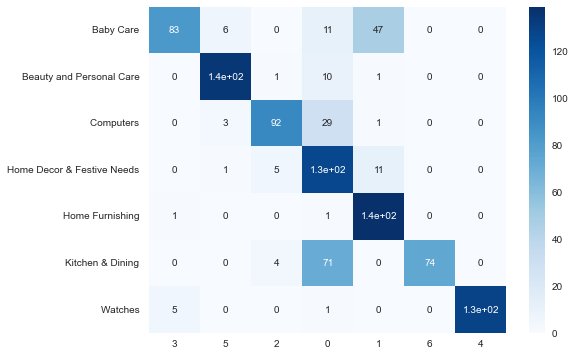

In [169]:
y_pred_use, ARI_use = clustering_7classes(X=features_use, labels=labels_bert)
visu_resultats(features=features_use, y_pred=y_pred_use,
               ARI=ARI_use, y_true=labels_bert)
erreur_attribution(y_true=labels_int_bert,
                   y_pred=y_pred_use, labels=labels_bert)



  Algorithme beaucoup plus rapide que BERT, améliore un peu les résultats

  ==> test avec corpus entier (description + specs)

In [170]:


def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    print(time2)
    return features



In [171]:
batch_size = 10
corpus_use = corpus_BoW



In [172]:
features_USE = feature_USE_fct(corpus_use, batch_size)



1.0


In [173]:
features_USE.shape



(1050, 512)

ARI : 0.687
Correspondance des clusters :  [5 4 2 6 1 0 3]
              precision    recall  f1-score   support

           0       0.99      0.56      0.71       150
           1       0.93      0.89      0.91       150
           2       0.92      0.99      0.95       150
           3       0.57      0.95      0.71       150
           4       0.80      0.99      0.89       150
           5       0.99      0.49      0.66       150
           6       1.00      0.99      1.00       150

    accuracy                           0.84      1050
   macro avg       0.89      0.84      0.83      1050
weighted avg       0.89      0.84      0.83      1050



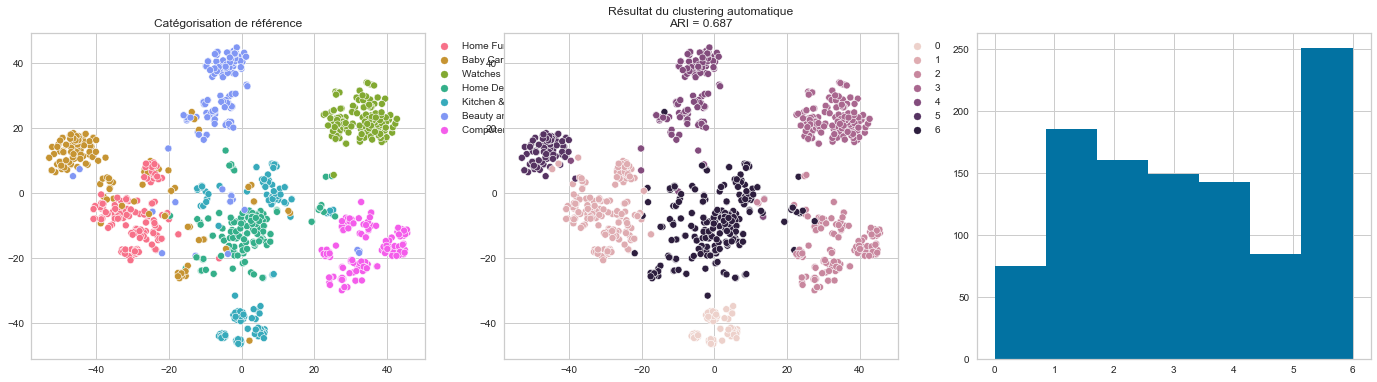

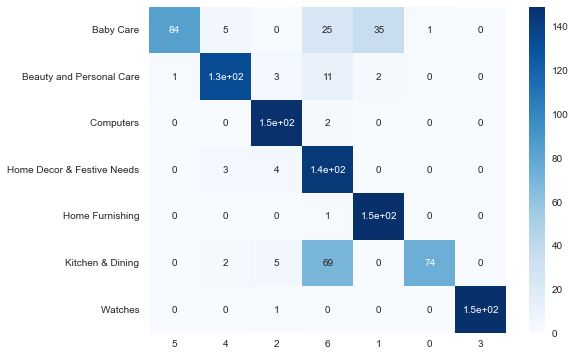

In [174]:
y_pred_USE, ARI_USE = clustering_7classes(X=features_USE, labels=labels)
visu_resultats(features=features_USE, y_pred=y_pred_USE,
               ARI=ARI_USE, y_true=labels)
erreur_attribution(y_true=labels_int, y_pred=y_pred_USE, labels=labels)


  Meilleur résultat avec l'intégralité du corpus et l'algorithme USE ne semble pas limité par la longueur des phrases.

  + plus rapide que BERT

  ==> a priori bonne recommandation pour la catégorisation automatique des produits


 ## Investigation des catégories mal identifiées par le clustering
 ### Baby Care

In [175]:
resultats = data[['uniq_id', 'product_name', 'image',
                  'description', 'product_specifications', 'categ_0']]
resultats['Cluster_USE'] = y_pred_USE


In [176]:
resultats.categ_0.unique()


array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [177]:
resultats[resultats.categ_0 == 'Baby Care '].Cluster_USE.value_counts()


5    84
1    35
6    25
4     5
0     1
Name: Cluster_USE, dtype: int64

 - Catégorie cluster 5 = Baby Care
 - catégorie cluster 1 = home Furnishing
 - catégorie cluster 6 = Home Decor & Festive needs
 - categorie cluster 4 = Beauty & personal care
 - categorie cluster 0 = Kitchen & dining

In [178]:
path = "C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Images/"


In [179]:
# Cluster 0 : 1 mauvaise attribution kitchen & dining
resultats[(resultats.categ_0 == 'Baby Care ') &
          (resultats.Cluster_USE == 0)].iloc[0, 3]


'Specifications of Doraemon Gift Family Ceramic Coffee Mug Multicolour Mug - 325 ml In The Box Sales Package Ceramic Coffee Mug General Type Mug Size in Number 9 inch Size Small'

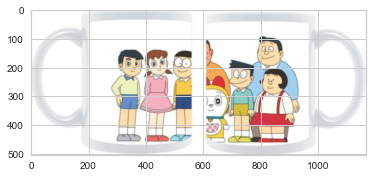

In [180]:
img = resultats[(resultats.categ_0 == 'Baby Care ') &
                (resultats.Cluster_USE == 0)].iloc[0, 2]
filename = path + img
image = imread(filename)
plt.imshow(image)


 Produit qui peut être attribué aux deux catégories.

Flipkart.com is offering Lollipop Lane Tiddly Wink Safari Bath Set for only for Rs 2950 | Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


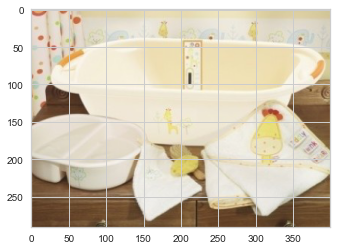


Shagun Gold Tea Tree Essential Aroma Therapy Oil (15 ml)
                         Price: Rs. 269
				
			Tea Tree Oil Is Derived From The Leaves Of The Tea Tree. The Tea Tree Was Named By Eighteenth Century Sailors, Who Made Tea That Smelled Like Nutmeg From The Leaves Of The Tree Growing On The Swampy Southeast Australian Coast. Do Not Confuse The Tea Tree With The Unrelated Common Tea Plant That Is Used To Make Black And Green Teas.
Tea Tree Oil Is Derived From The Leaves Of The Tea Tree. The Tea Tree Was Named By Eighteenth Century Sailors, Who Made Tea That Smelled Like Nutmeg From The Leaves Of The Tree Growing On The Swampy Southeast Australian Coast. Do Not Confuse The Tea Tree With The Unrelated Common Tea Plant That Is Used To Make Black And Green Teas.


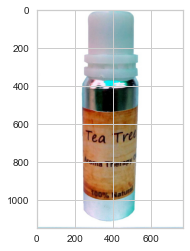


Specifications of Portia Hat (Pink, Pack of 1) In The Box Number of Contents in Sales Package Pack of 1 General Ideal For Girls


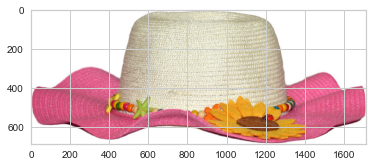


Key Features of TRESemme Naturals Vibrantly Smooth Shampoo Ideal for: Boys, Girls Skin Type: All Skin Types Form: Liquid,TRESemme Naturals Vibrantly Smooth Shampoo (591) Price: Rs. 2,063 Naturals vibrantly smooth shampo.Large 25 ounce size. Tresemme naturals vibrantly smooth shampo,Specifications of TRESemme Naturals Vibrantly Smooth Shampoo (591) Body Wash Essentials Form Liquid Skin Type All Skin Types Ideal For Boys, Girls General Traits Brand TRESemme Quantity 591 Model Name Naturals Vibrantly Smooth Shampoo Model ID TRE-7760 In the Box 1 Smoothing Shampoo


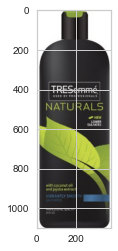


Key Features of L Oreal Eversleek Sulfate - Free Smoothing System Intense Smoothing Shampoo Ideal for: Boys, Girls Skin Type: All Skin Types Form: Liquid,L Oreal Eversleek Sulfate - Free Smoothing System Intense Smoothing Shampoo (250) Price: Rs. 1,365 Sulfate and silicon-free smoothing shampoo gently cleanses while weightlessly smoothing frizzy, unruly ha, Formulated with natural botanicals, oils, and sunflower for 48-hour frizz contrl, Improves texture, and leaves hair beautifully sleek and manageal,,Specifications of L Oreal Eversleek Sulfate - Free Smoothing System Intense Smoothing Shampoo (250) Body Wash Essentials Form Liquid Skin Type All Skin Types Ideal For Boys, Girls General Traits Brand L Oreal Quantity 250 Model Name Eversleek Sulfate - Free Smoothing System Intense Smoothing Shampoo In the Box 1 Smoothing Shampoo


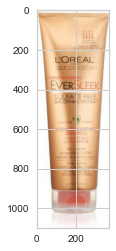

In [181]:
# Cluster 4 : 5 mauvaise attribution à Beauty & Personal care
for i in range(5):
    print(resultats[(resultats.categ_0 == 'Baby Care ')
          & (resultats.Cluster_USE == 4)].iloc[i, 3])
    img = resultats[(resultats.categ_0 == 'Baby Care ') &
                    (resultats.Cluster_USE == 4)].iloc[i, 2]
    filename = path + img
    image = imread(filename)
    plt.imshow(image)
    plt.show()
    print('')


 ==> Produits pouvant être catégorisés dans les deux catégories.

Key Features of KOHL Wine Bag Yellow Easy to carry GiftBags JuteBags Bits&Bobs,Specifications of KOHL Wine Bag Yellow (Yellow) General Brand KOHL Insulated No Type Bottle Cover Series Wine Bags Material Jute Washable Yes Model Name Wine Bag Yellow Ideal For Boys, Girls Model ID 3 Color Yellow Size Large In the Box Number of Contents in Sales Package 1 Sales Package Bottle Cover Additional Features Easy to carry, GiftBags, JuteBags, Bits&Bobs


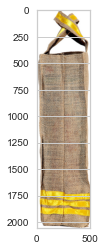


Buy Bestway 1.47m x 1.47m x 1.22m/Play With Sun Shade Inflatable Play Pool for Rs.2499 online. Bestway 1.47m x 1.47m x 1.22m/Play With Sun Shade Inflatable Play Pool at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


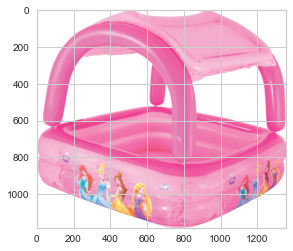


Specifications of BASRA uepgrn Green Changing Table General Brand BASRA Model Number tab-pgrn01 Shade green Model Name uepgrn Color Green Body and Design Features Changing Pad Included No Safety Strap Included No Material Plastic Wheels Included No Dimensions Weight 3.5 kg Height 21 cm Width 12 cm Depth 12 cm In the Box changing table Additional Features Other Features easily to use


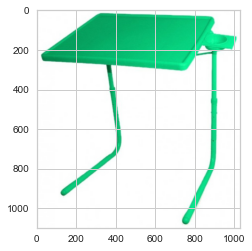


Specifications of Graco LiteRider Click Connect � Marco (Multicolor) General Foldable Yes Age Group 0 - 3 Years Type Stroller Ideal For Boys, Girls Weight Supported 18 kg Wheel Features Wheeled Bottom Yes Other Wheel Features Lockable Wheel Type Swivel & Fixed Dimensions Weight 7.66 kg Height 31.1 inch Width 17.75 inch Depth 9.64 inch Safety Features Locking System Yes In the Box Number of Contents in Sales Package 1 Sales Package 1 Stroller Body Features Storage Basket Yes Recline Settings 2 Position Number of Cup Holders 2 Cup Holder Yes Material Lightweight Aluminium Leg Rest Type Adjustable Canopy Yes


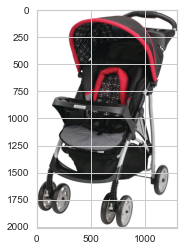


Specifications of Boreal Plastic rectangular hair brush 633D Brush Traits Brush Type Flat brush Brush Set Content Small brush Bristle Type Nylon bristles Round Tip Bristle Yes Handle Type Plastic handle Brush Application Grooming, Curling, Detangling Ideal For BoysIIGirls Brush Size Small Brush Set No Suitable Hair Type Medium to long hair, Wet hair In the Box Hair brush Additional Traits Reduces snags and tangles


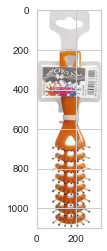


Buy Wood Beauty Wood Photo Frame for Rs.450 online. Wood Beauty Wood Photo Frame at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


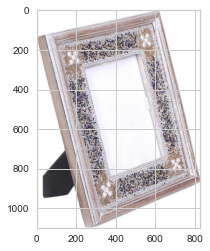


Buy Munchkin Mighty Grip Trainer Cup for Rs.349 online. Munchkin Mighty Grip Trainer Cup at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


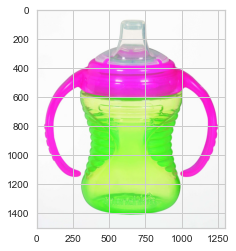


Buy Blue Bell Popfun Sipper for Rs.180 online. Blue Bell Popfun Sipper at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


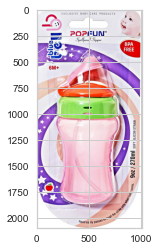


Buy MH MDF Photo Frame for Rs.899 online. MH MDF Photo Frame at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


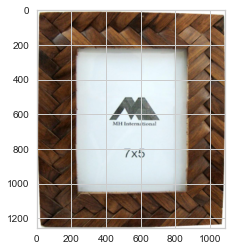


Indha Craft Cloth Photo Frame (Photo Size - 12.7 X 17.8 cm, 1 Photos)
                         Price: Rs. 132
				
			The outer shell of this frame is made up of Polyster bland fabric and hard board Fabric and inner material is carbord. The photo of this frame is 5 x 3 inches.
The outer shell of this frame is made up of Polyster bland fabric and hard board Fabric and inner material is carbord. The photo of this frame is 5 x 3 inches.


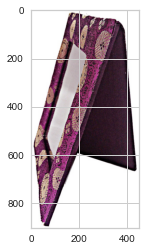


Cocovey Metal Photo Frame (Photo Size - 6*4, 1 Photos)
                         Price: Rs. 549
				
			Add traditional and stylish look to your house with Cocovey handcrafted photo frames. This beautifully crafted photo frame is made of brass. Its traditional tribal and cultural design is unique and brings style to your home. Indian homes are getting stylish with time as there is more excitement towards interior home décor.Our company is an effort to perceive that excitement and help you choose your favorites from a wide range of such painstakingly pursued beautiful handicraft items; as they find their way from the skilled hands of craftsmen directly to that precious place in your abode.
Add traditional and stylish look to your house with Cocovey handcrafted photo frames. This beautifully crafted photo frame is made of brass. Its traditional tribal and cultural design is unique and brings style to your home. Indian homes are getting stylish with time as there is more excitement toward

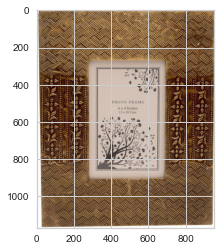


Flipkart.com is offering Small Funcart Party Time  - Food Grade Plastic for only for Rs 154 | Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


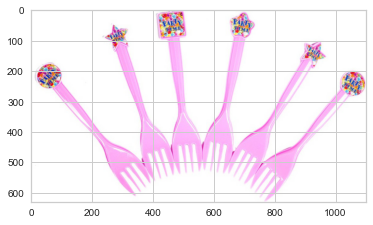


Flipkart.com is offering EZ Life Funky 3-Pc Kids Cutlery Set-Pleasing Panda  - Stainless Steel, Food Grade Plastic for only for Rs 399 | Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


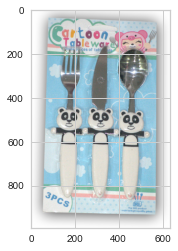


Flipkart.com is offering Small Funcart Frolic Birthday  - Food Grade Plastic for only for Rs 154 | Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


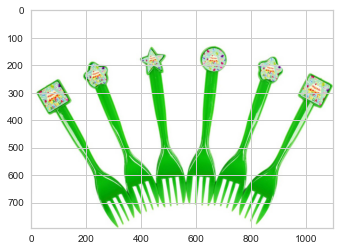


Buy Intex Kids Inflatable Air Chair for Rs.429 online. Intex Kids Inflatable Air Chair at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


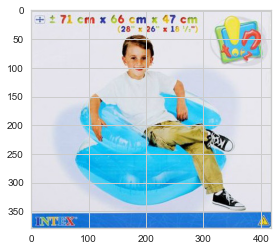


Buy Elite Collection Medium Acrylic Sticker for Rs.999 online. Elite Collection Medium Acrylic Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


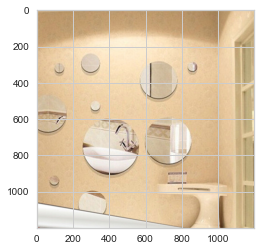


Buy Wallmantra Extra Large Vinyl Stickers Sticker for Rs.1216 online. Wallmantra Extra Large Vinyl Stickers Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


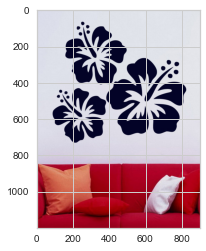


Buy WallDesign Small Vinyl Sticker for Rs.730 online. WallDesign Small Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


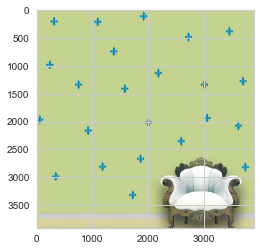


Buy 999store Medium Paper Sticker for Rs.599 online. 999store Medium Paper Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


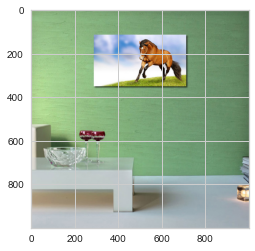


Buy Wallmantra Medium Vinyl Stickers Sticker for Rs.1143 online. Wallmantra Medium Vinyl Stickers Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


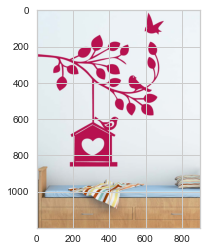


Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)
                         Price: Rs. 999
				
			Double sticker can be used for the big walls. Two pieces is there that can be arranged alternatively or reflectively. This will d�cor the wall like 3d look. Tree with the green shaded leaves will give the sharp feature of the greenery. Reusable i.e. Can be used again after applied once. Simple remove and re-use the sticker on same or another wall with a different idea

How to install?

1) The surface you wish to attach your decal must be clean 
and free from dust, grease or any other contamination.
 
2) Simply peel those pre-cut pieces of wall stickers off from 
backing paper and apply them on the desired area.
NOTE: 
1. Freshly painted or lacquered 
surfaces must be allowed to completely cure before the decal is applied. We 
recommend waiting for minimum of 2-3 weeks. 2. 
We discourage installation on certain surfaces such as brick, stucco, concrete 
block, suede paints, and san

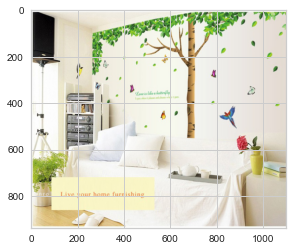


Wallmantra Large Vinyl Sticker Sticker (Pack of 1)
                         Price: Rs. 1,896
				
			Bring home this exclusive Piece of Wall Art to give your home a refreshing look it deserves !
Wall Decals are the latest trend, sweeping the world of interior design, as a quick and easy way to personalise and transform your home. We at Wallmantra use only the highest quality premium self-adhesive vinyl for our products to ensure you receive the best quality product.
The sizes are in inches (Width x Height), rounded to the nearest inch. The size of the product is the final size that will be up on the walls . 
These are very easy to apply and remove. You can apply these yourself. We send ready to apply Decal/Sticker with 2 practice items with instruction manual. You can also see the how to apply video.
These are not re-usable.
 Contact Wallmantra for more options
Bring home this exclusive Piece of Wall Art to give your home a refreshing look it deserves !
Wall Decals are the latest tren

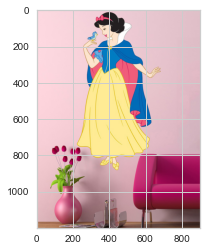


Buy Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker for Rs.1449 online. Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


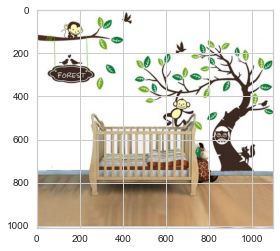


Buy Wallmantra Medium Vinyl Sticker Sticker for Rs.1333 online. Wallmantra Medium Vinyl Sticker Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


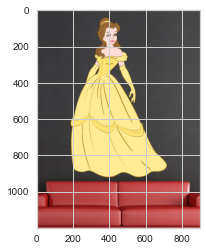


Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


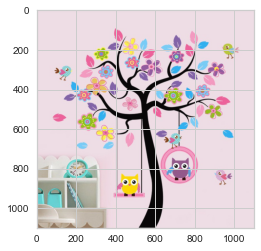

In [182]:
# Cluster 6 : 25 mauvaise attribution à Home Decor & Festive Needs
for i in range(25):
    print(resultats[(resultats.categ_0 == 'Baby Care ')
          & (resultats.Cluster_USE == 6)].iloc[i, 3])
    img = resultats[(resultats.categ_0 == 'Baby Care ') &
                    (resultats.Cluster_USE == 6)].iloc[i, 2]
    filename = path + img
    image = imread(filename)
    plt.imshow(image)
    plt.show()
    print('')


 - Certains articles ne sont pas correctement catégorisés comme les cadres photos => il faudrait revoir la catégorisation des vendeurs
 - d'autre articles sont clairement destinés à des enfants, mais peuvent se retrouver dans d'autres catégories (couverts, stickers de décoration)

 ==> Il sera interessant de coupler les features issues du texte avec celles issues des images.

In [183]:
# Export features_USE
# data_to_export = data[['uniq_id', 'image', 'categ_0']]
# data_to_export.to_csv('../01_DATA/target.csv')
np.savetxt('../01_DATA/features_USE.csv', features_USE, delimiter=',')
